## Importing necessary libraries

In [88]:
import pandas as pd
import math
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from scipy.stats import pointbiserialr
import pingouin as pg
import os
from collections import defaultdict
import re

## Loading the transposed merged dataframe

In [89]:
df=pd.read_csv("processed_1.csv")
df=df.drop(["Unnamed: 0"],axis=1)
dff=df
df

,PatientIDWoundNumber,FinalVisit_Healing_Status,AccidentType,Anterior_Posterior,Anterior_Dorsal,DateInactive,DateOfAccident,DateWoundHealed,Inferior_Superior,Left_Right,...,TendonNecrosisExposed_Visit15,tunneling_Visit15,TunnelingOrUndermining_Visit15,woundProgress_Visit15,GranulationTexture_Visit15,WoundMargin_Visit15,eschar_Visit15,Wound_healing_status_Visit15,DayNumber_Visit15,DateAcquired_2
0,0,0,0,0,2,1561,528,1576,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,437
1,1,3,0,2,1,1561,528,1576,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2420
2,2,0,0,2,1,1561,528,1576,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,452
3,3,0,0,2,2,1561,528,1576,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,904
4,4,2,0,2,2,1561,528,1576,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17700,22297,1,0,2,2,1561,528,1576,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2420
17701,22298,1,0,2,2,1561,528,1576,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,262
17702,22299,3,0,0,2,1561,528,1576,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248
17703,22300,0,0,0,2,1561,528,1576,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248


In [90]:
df_dropped=df

In [91]:
df_dropped["FinalVisit_Healing_Status"].value_counts()

FinalVisit_Healing_Status
3    6984
1    5745
2    2699
0    2277
Name: count, dtype: int64

## We realized imagefilecount on each visit really does not help heal the wounds, because it depends on the caregiver or someone who took the assessment's photo. So we want to remove that.

In [92]:
columns_to_remove = df_dropped.columns[df_dropped.columns.str.startswith('imageFileCount')]

# Remove the columns starting with 'imageFileCount'
df_dropped = df_dropped.drop(columns=columns_to_remove)

#columns_to_remove = df_dropped.columns[df_dropped.columns.str.startswith('Wound_healing_status')]

# Remove the columns starting with 'imageFileCount'
#df_dropped = df_dropped.drop(columns=columns_to_remove)

In [93]:
columns_to_remove = df_dropped.columns[df_dropped.columns.str.startswith('DayNumber')]

# Remove the columns starting with 'imageFileCount'
df_dropped = df_dropped.drop(columns=columns_to_remove)

df_dropped = df_dropped.drop(["PatientIDWoundNumber", "DateInactive","DateOfAccident"],axis=1)

# Q1 = df_reduced['BMI'].quantile(0.25)
# Q3 = df_reduced['BMI'].quantile(0.75)
# IQR = Q3 - Q1

# # Define the acceptable range for 'BMI' values
# lower_bound = Q1 - 3 * IQR
# upper_bound = Q3 + 3 * IQR

# # Filter rows within the acceptable range
# df_reduced= df_reduced[(df_reduced['BMI'] >= lower_bound) & (df_reduced['BMI'] <= upper_bound)]
df_dropped

,FinalVisit_Healing_Status,AccidentType,Anterior_Posterior,Anterior_Dorsal,DateWoundHealed,Inferior_Superior,Left_Right,Location,Proximal_Distal,ResolvedRecurrence,...,Temperature_Visit15,TendonNecrosisExposed_Visit15,tunneling_Visit15,TunnelingOrUndermining_Visit15,woundProgress_Visit15,GranulationTexture_Visit15,WoundMargin_Visit15,eschar_Visit15,Wound_healing_status_Visit15,DateAcquired_2
0,0,0,0,2,1576,2,1,21,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,437
1,3,0,2,1,1576,2,1,34,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2420
2,0,0,2,1,1576,1,2,34,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,452
3,0,0,2,2,1576,2,1,34,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,904
4,2,0,2,2,1576,2,1,22,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17700,1,0,2,2,1576,2,0,3,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2420
17701,1,0,2,2,1576,2,0,78,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,262
17702,3,0,0,2,1576,2,0,21,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248
17703,0,0,0,2,1576,2,0,21,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248


In [94]:
# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Iterate over each column in the dataframe
for column in df_dropped.columns:
    print(column)
    # Check if the column is of object or categorical type
    if df_dropped[column].dtype == 'object':
        # Convert the column to string type
        df_dropped[column] = df_dropped[column].astype(str)
        
        # Fit and transform the categorical column
        df_dropped[column] = label_encoder.fit_transform(df_dropped[column])

FinalVisit_Healing_Status
AccidentType
Anterior_Posterior
Anterior_Dorsal
DateWoundHealed
Inferior_Superior
Left_Right
Location
Proximal_Distal
ResolvedRecurrence
ResultOfAccident
Type
WoundCondition
woundstatus
AdmissionDate
AdmissionStatusCode
MedicareAdmission
NonWoundDiagnosis
PalliativeCare
StartDate
CauseOfDeath
DateOfDeath
ethnicityCdcCode
PatientDOB
PatientGender
PatientSelfCare
PatientZIP
RaceCodeList
Religion
DateAdded_patient
Age
Height
Weight
Patient_RiskLevel
Patient_Score
SmokingStatus
SmokingStatusText
DebridementLevel
Method
Bleeding
IsThisBurn
SInsuranceZip
PInsuranceZip
AdiposeExposed_Visit1
AdiposeNecrosisExposed_Visit1
area_Visit1
BrawnyInduration_Visit1
Callus_Visit1
color_Visit1
CompCompression_Visit1
Denuded_Visit1
Depth_Visit1
DryScaly_Visit1
Ecchymosis_Visit1
Edema_Visit1
Erythema_Visit1
Excoriation_Visit1
ExposedMuscle_Visit1
ExposedTendon_Visit1
Exudate_Visit1
ExudateAmount_Visit1
Fluctuance_Visit1
Friable_Visit1
greygran_Visit1
Hemosiderosis_Visit1
Induratio

In [95]:
prefixes_to_convert = ['Method', 'SmokingStatus', 'NonWoundDiagnosis', 'PatientGender',
    'MedicareAdmission', 'SmokingStatusText', 'WoundCondition', 'Location',
    'AdmissionStatusCode', 'Religion', 'Depth', 'Pain', 'GranulationTexture',
    'ExudateAmount', 'NormalColor', 'PalliativeCare', 'Patient_RiskLevel',
    'color', 'Exudate', 'Type', 'RedGranulation', 'Left_Right', 'PatientDOB',
    'WoundMargin', 'tunneling', 'RaceCodeList', 'PatientSelfCare', 'PInsuranceZip',
    'Bleeding', 'surroundingSkin', 'surroundingSkinColor', 'Anterior_Dorsal',
    'CauseOfDeath', 'Proximal_Distal', 'woundstatus', 'ActiveWound',
    'Inferior_Superior', 'normalTexture', 'ResolvedRecurrence', 'Stage',
    'slough', 'IsThisBurn', 'woundProgress', 'Notes', 'CompCompression',
    'SloughLessThan20', 'Anterior_Posterior', 'Odor', 'eschar',
    'TunnelingOrUndermining', 'SSXRay', 'Patient_Title', 'NormalMoisture',
    'ResolvedRecurrence', 'Stage', 'IsThisBurn', 'CompCompression',
    'SloughLessThan20', 'Anterior_Posterior', 'Odor', 'eschar',
    'TunnelingOrUndermining', 'SSXRay', 'Patient_Title', 'NormalMoisture',
    'ResolvedRecurrence','FinalVisit_Healing_Status','PatientZIP',
      'AllVisit_woundProgress', "Wound_healing_status", "AccidentType", "SInsuranceZip", "AdiposeExposed", "Rash",
      "ethnicityCdcCode","CompDiet","Excoriation","AtrophieBlanche","Denuded", "Fluctuance","Moist", "NormalMoisture",
      "Shiny","Erythema","SSCAndSPending", "SSSignsAndSymptoms", "sinustract", "pinkgran", "greygran", "Crepitus",
      "Rubor", "SystematicInfection", "Callus", "DryScaly", "ResultOfAccident", "Induration", "NoMeasurableDepth",
      "SSConfirmedLocal", "TendonNecrosisExposed", "Edema", "Friable", "BrawnyInduration", "Ecchymosis",
      "SSSystemicAntibiotics", "Ecchymosis", "ExposedMuscle", "Maceration", "Hemosiderosis", "redgran", "Scarring"]

# Iterate over columns
for col in df_dropped.columns:
    for prefix in prefixes_to_convert:
        if col.startswith(prefix) or col == prefix:
            df_dropped[col] = df_dropped[col].astype('category')

# Verify the changes
print(df_dropped.dtypes)

FinalVisit_Healing_Status       category
AccidentType                    category
Anterior_Posterior              category
Anterior_Dorsal                 category
DateWoundHealed                    int64
                                  ...   
GranulationTexture_Visit15      category
WoundMargin_Visit15             category
eschar_Visit15                  category
Wound_healing_status_Visit15    category
DateAcquired_2                     int64
Length: 899, dtype: object


In [96]:
# df_dropped = df_dropped.fillna(-99999)
# df_dropped=df_dropped.replace([np.inf, -np.inf], -99999)
# df_dropped

In [97]:
df_dropped

,FinalVisit_Healing_Status,AccidentType,Anterior_Posterior,Anterior_Dorsal,DateWoundHealed,Inferior_Superior,Left_Right,Location,Proximal_Distal,ResolvedRecurrence,...,Temperature_Visit15,TendonNecrosisExposed_Visit15,tunneling_Visit15,TunnelingOrUndermining_Visit15,woundProgress_Visit15,GranulationTexture_Visit15,WoundMargin_Visit15,eschar_Visit15,Wound_healing_status_Visit15,DateAcquired_2
0,0,0,0,2,1576,2,1,21,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,437
1,3,0,2,1,1576,2,1,34,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2420
2,0,0,2,1,1576,1,2,34,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,452
3,0,0,2,2,1576,2,1,34,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,904
4,2,0,2,2,1576,2,1,22,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17700,1,0,2,2,1576,2,0,3,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2420
17701,1,0,2,2,1576,2,0,78,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,262
17702,3,0,0,2,1576,2,0,21,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248
17703,0,0,0,2,1576,2,0,21,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248


## Removing highly correlated features

In [98]:
# Example dataset (replace this with your actual dataset)
data = df_dropped

# Custom correlation function to handle NaN values
def custom_correlation(x, y, method):
    valid_values = ~np.isnan(x) & ~np.isnan(y)
    x_valid = x[valid_values]
    y_valid = y[valid_values]
    
    if method == 'pearson':
        # Handle NaN values for Pearson correlation
        mask = np.isfinite(x_valid) & np.isfinite(y_valid)
        correlation_result = pointbiserialr(x_valid[mask], y_valid[mask])
    elif method == 'pointbiserial':
        correlation_result = pointbiserialr(x_valid, y_valid)
    else:
        raise ValueError(f"Unsupported correlation method: {method}")
    
    return correlation_result

# Create an empty dictionary to store correlation results
correlation_results = {}

# Iterate through numerical columns
for numerical_var in data.select_dtypes(include=['float64', 'int64']).columns:
    # Iterate through all columns
    for column in data.columns:
        # Skip the numerical variable itself
        if column == numerical_var:
            continue
        
        # Determine data types
        data_type_numerical = data[numerical_var].dtype
        data_type_column = data[column].dtype
        
        # Apply the appropriate correlation method based on data types
        if data_type_numerical in ['float64', 'int64'] and data_type_column in ['float64', 'int64']:
            # Both variables are numerical - use Pearson correlation
            correlation_result = custom_correlation(data[numerical_var], data[column], 'pearson')
        elif data_type_numerical in ['float64', 'int64'] and data_type_column == 'object':
            # Numerical variable and categorical variable - use point-biserial correlation
            # Convert binary categorical data to numeric
            data_numeric = pd.Categorical(data[column]).codes
            correlation_result = custom_correlation(data[numerical_var], data_numeric, 'pointbiserial')
        # Add other cases as needed
        else:
            # Other combinations - skip or handle accordingly
            continue
        
        # Store the correlation result
        key = f"{numerical_var}_vs_{column}"
        correlation_results[key] = correlation_result

# Print the results
for key, result in correlation_results.items():
    print(f"Correlation {key}:\n{result}\n")


Correlation DateWoundHealed_vs_AdmissionDate:
SignificanceResult(statistic=0.0013376053069611418, pvalue=0.8587469613888737)

Correlation DateWoundHealed_vs_StartDate:
SignificanceResult(statistic=-0.009756938184335243, pvalue=0.1942190425049179)

Correlation DateWoundHealed_vs_DateOfDeath:
SignificanceResult(statistic=-0.0016555507482649851, pvalue=0.8256590086114018)

Correlation DateWoundHealed_vs_DateAdded_patient:
SignificanceResult(statistic=0.013358761479557467, pvalue=0.07549054222234075)

Correlation DateWoundHealed_vs_Age:
SignificanceResult(statistic=-0.009215749104964617, pvalue=0.2201408556784635)

Correlation DateWoundHealed_vs_Height:
SignificanceResult(statistic=-0.0072321248661404314, pvalue=0.3921399361613685)

Correlation DateWoundHealed_vs_Weight:
SignificanceResult(statistic=-0.0038376014052481874, pvalue=0.6507644965873772)

Correlation DateWoundHealed_vs_Patient_Score:
SignificanceResult(statistic=0.006512268233868663, pvalue=0.41114274102232934)

Correlation Dat

## Removing features using feature importance

In [99]:
# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Iterate over each column in the dataframe
for column in df_dropped.columns:
    print(column)
    # Check if the column is of object or categorical type
    if df_dropped[column].dtype == 'category':
        # Convert the column to string type
        df_dropped[column] = df_dropped[column].astype('str')
        
        # Fit and transform the categorical column
        df_dropped[column] = label_encoder.fit_transform(df_dropped[column])

FinalVisit_Healing_Status
AccidentType
Anterior_Posterior
Anterior_Dorsal
DateWoundHealed
Inferior_Superior
Left_Right
Location
Proximal_Distal
ResolvedRecurrence
ResultOfAccident
Type
WoundCondition
woundstatus
AdmissionDate
AdmissionStatusCode
MedicareAdmission
NonWoundDiagnosis
PalliativeCare
StartDate
CauseOfDeath
DateOfDeath
ethnicityCdcCode
PatientDOB
PatientGender
PatientSelfCare
PatientZIP
RaceCodeList
Religion
DateAdded_patient
Age
Height
Weight
Patient_RiskLevel
Patient_Score
SmokingStatus
SmokingStatusText
DebridementLevel
Method
Bleeding
IsThisBurn
SInsuranceZip
PInsuranceZip
AdiposeExposed_Visit1
AdiposeNecrosisExposed_Visit1
area_Visit1
BrawnyInduration_Visit1
Callus_Visit1
color_Visit1
CompCompression_Visit1
Denuded_Visit1
Depth_Visit1
DryScaly_Visit1
Ecchymosis_Visit1
Edema_Visit1
Erythema_Visit1
Excoriation_Visit1
ExposedMuscle_Visit1
ExposedTendon_Visit1
Exudate_Visit1
ExudateAmount_Visit1
Fluctuance_Visit1
Friable_Visit1
greygran_Visit1
Hemosiderosis_Visit1
Induratio

In [100]:
df=df_dropped

target_column='FinalVisit_Healing_Status'

X = df.drop([target_column], axis=1)
y = df[target_column]

# Fit Random Forest regressor
rf = XGBClassifier()
rf.fit(X, y)

for key, result in correlation_results.items():
    #print(key)
    # Split the string into two parts
    split_parts = key.split('_vs_')
    # Display the result
    
    
    if abs(round(result[0],4))>0.8:
        
        print(split_parts)
        print("Correlation Coeff:",round(result[0],4))
        feature1=split_parts[0]
        feature2=split_parts[1]

        columns_to_check = [feature1, feature2]

        # Iterate through the columns and check if each column is present
        if set(columns_to_check).issubset(df.columns):
            print("Both columns are present in the DataFrame.")

            # Print feature importance
            print(f"\nFeature Importance for {feature1}: {pd.Series(rf.feature_importances_, index=X.columns)[feature1]}")
            print(f"Feature Importance for {feature2}: {pd.Series(rf.feature_importances_, index=X.columns)[feature2]}")

            feature_1_importance=pd.Series(rf.feature_importances_, index=X.columns)[feature1]
            feature_2_importance=pd.Series(rf.feature_importances_, index=X.columns)[feature2]

            # Drop the less important feature
            if feature_1_importance < feature_2_importance:
                df.drop(feature1, axis=1, inplace=True)
                print("Dropping",feature1,"\n")
            else:
                df.drop(feature2, axis=1, inplace=True)
                print("Dropping",feature2,"\n")

    # Display the modified DataFrame
display(df)

['AdiposeNecrosisExposed_Visit1', 'AdiposeNecrosisExposed_Visit2']
Correlation Coeff: 0.8432
Both columns are present in the DataFrame.

Feature Importance for AdiposeNecrosisExposed_Visit1: 0.00032843704684637487
Feature Importance for AdiposeNecrosisExposed_Visit2: 0.00036157158319838345
Dropping AdiposeNecrosisExposed_Visit1 

['area_Visit1', 'area_Visit2']
Correlation Coeff: 0.8241
Both columns are present in the DataFrame.

Feature Importance for area_Visit1: 0.0002762973017524928
Feature Importance for area_Visit2: 0.005746916402131319
Dropping area_Visit1 

['ExposedTendon_Visit1', 'ExposedTendon_Visit2']
Correlation Coeff: 0.8475
Both columns are present in the DataFrame.

Feature Importance for ExposedTendon_Visit1: 6.708555883960798e-05
Feature Importance for ExposedTendon_Visit2: 4.619918763637543e-05
Dropping ExposedTendon_Visit2 

['Temperature_Visit1', 'Temperature_Visit2']
Correlation Coeff: 0.8045
Both columns are present in the DataFrame.

Feature Importance for Temper

,FinalVisit_Healing_Status,AccidentType,Anterior_Posterior,Anterior_Dorsal,DateWoundHealed,Inferior_Superior,Left_Right,Location,Proximal_Distal,ResolvedRecurrence,...,SystematicInfection_Visit15,TendonNecrosisExposed_Visit15,tunneling_Visit15,TunnelingOrUndermining_Visit15,woundProgress_Visit15,GranulationTexture_Visit15,WoundMargin_Visit15,eschar_Visit15,Wound_healing_status_Visit15,DateAcquired_2
0,0,0,0,2,1576,2,1,14,2,2,...,3,3,4,3,5,4,11,16,4,437
1,3,0,2,1,1576,2,1,28,2,1,...,3,3,4,3,5,4,11,16,4,2420
2,0,0,2,1,1576,1,2,28,2,1,...,3,3,4,3,5,4,11,16,4,452
3,0,0,2,2,1576,2,1,28,2,1,...,3,3,4,3,5,4,11,16,4,904
4,2,0,2,2,1576,2,1,15,2,2,...,3,3,4,3,5,4,11,16,4,2483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17700,1,0,2,2,1576,2,0,23,2,1,...,3,3,4,3,5,4,11,16,4,2420
17701,1,0,2,2,1576,2,0,76,2,1,...,3,3,4,3,5,4,11,16,4,262
17702,3,0,0,2,1576,2,0,14,2,2,...,3,3,4,3,5,4,11,16,4,248
17703,0,0,0,2,1576,2,0,14,2,2,...,3,3,4,3,5,4,11,16,4,248


In [101]:
df

,FinalVisit_Healing_Status,AccidentType,Anterior_Posterior,Anterior_Dorsal,DateWoundHealed,Inferior_Superior,Left_Right,Location,Proximal_Distal,ResolvedRecurrence,...,SystematicInfection_Visit15,TendonNecrosisExposed_Visit15,tunneling_Visit15,TunnelingOrUndermining_Visit15,woundProgress_Visit15,GranulationTexture_Visit15,WoundMargin_Visit15,eschar_Visit15,Wound_healing_status_Visit15,DateAcquired_2
0,0,0,0,2,1576,2,1,14,2,2,...,3,3,4,3,5,4,11,16,4,437
1,3,0,2,1,1576,2,1,28,2,1,...,3,3,4,3,5,4,11,16,4,2420
2,0,0,2,1,1576,1,2,28,2,1,...,3,3,4,3,5,4,11,16,4,452
3,0,0,2,2,1576,2,1,28,2,1,...,3,3,4,3,5,4,11,16,4,904
4,2,0,2,2,1576,2,1,15,2,2,...,3,3,4,3,5,4,11,16,4,2483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17700,1,0,2,2,1576,2,0,23,2,1,...,3,3,4,3,5,4,11,16,4,2420
17701,1,0,2,2,1576,2,0,76,2,1,...,3,3,4,3,5,4,11,16,4,262
17702,3,0,0,2,1576,2,0,14,2,2,...,3,3,4,3,5,4,11,16,4,248
17703,0,0,0,2,1576,2,0,14,2,2,...,3,3,4,3,5,4,11,16,4,248


In [102]:
df_reduced=df

In [103]:
prefixes_to_convert = ['Method', 'SmokingStatus', 'NonWoundDiagnosis', 'PatientGender',
    'MedicareAdmission', 'SmokingStatusText', 'WoundCondition', 'Location',
    'AdmissionStatusCode', 'Religion', 'Depth', 'Pain', 'GranulationTexture',
    'ExudateAmount', 'NormalColor', 'PalliativeCare', 'Patient_RiskLevel',
    'color', 'Exudate', 'Type', 'RedGranulation', 'Left_Right', 'PatientDOB',
    'WoundMargin', 'tunneling', 'RaceCodeList', 'PatientSelfCare', 'PInsuranceZip',
    'Bleeding', 'surroundingSkin', 'surroundingSkinColor', 'Anterior_Dorsal',
    'CauseOfDeath', 'Proximal_Distal', 'woundstatus', 'ActiveWound',
    'Inferior_Superior', 'normalTexture', 'ResolvedRecurrence', 'Stage',
    'slough', 'IsThisBurn', 'woundProgress', 'Notes', 'CompCompression',
    'SloughLessThan20', 'Anterior_Posterior', 'Odor', 'eschar',
    'TunnelingOrUndermining', 'SSXRay', 'Patient_Title', 'NormalMoisture',
    'ResolvedRecurrence', 'Stage', 'IsThisBurn', 'CompCompression',
    'SloughLessThan20', 'Anterior_Posterior', 'Odor', 'eschar',
    'TunnelingOrUndermining', 'SSXRay', 'Patient_Title', 'NormalMoisture',
    'ResolvedRecurrence','FinalVisit_Healing_Status','PatientZIP',
    'AllVisit_woundProgress', "Wound_healing_status", "AccidentType", "SInsuranceZip", "AdiposeExposed", "Rash",
    "ethnicityCdcCode","CompDiet","Excoriation","AtrophieBlanche","Denuded", "Fluctuance","Moist", "NormalMoisture",
      "Shiny","Erythema","SSCAndSPending", "SSSignsAndSymptoms", "sinustract", "pinkgran", "greygran", "Crepitus",
      "Rubor", "SystematicInfection", "Callus", "DryScaly", "ResultOfAccident", "Induration", "NoMeasurableDepth",
      "SSConfirmedLocal", "TendonNecrosisExposed", "Edema", "Friable", "BrawnyInduration", "Ecchymosis",
      "SSSystemicAntibiotics", "Ecchymosis", "ExposedMuscle", "Maceration", "Hemosiderosis", "redgran", "Scarring"]

# Iterate over columns
for col in df_reduced.columns:
    for prefix in prefixes_to_convert:
        if col.startswith(prefix) or col == prefix:
            df_reduced[col] = df_reduced[col].astype('category')

# Verify the changes
print(df_reduced.dtypes)

FinalVisit_Healing_Status       category
AccidentType                    category
Anterior_Posterior              category
Anterior_Dorsal                 category
DateWoundHealed                    int64
                                  ...   
GranulationTexture_Visit15      category
WoundMargin_Visit15             category
eschar_Visit15                  category
Wound_healing_status_Visit15    category
DateAcquired_2                     int64
Length: 851, dtype: object


In [104]:
# Example dataset (replace this with your actual dataset)
data = df_reduced

# Custom correlation function to handle NaN values
def custom_correlation(x, y, method):
    valid_values = ~np.isnan(x) & ~np.isnan(y)
    x_valid = x[valid_values]
    y_valid = y[valid_values]
    
    if method == 'pearson':
        # Handle NaN values for Pearson correlation
        mask = np.isfinite(x_valid) & np.isfinite(y_valid)
        correlation_result = pointbiserialr(x_valid[mask], y_valid[mask])
    elif method == 'pointbiserial':
        correlation_result = pointbiserialr(x_valid, y_valid)
    else:
        raise ValueError(f"Unsupported correlation method: {method}")
    
    return correlation_result

# Create an empty dictionary to store correlation results
correlation_results = {}

# Iterate through numerical columns
for numerical_var in data.select_dtypes(include=['float64', 'int64']).columns:
    # Iterate through all columns
    for column in data.columns:
        # Skip the numerical variable itself
        if column == numerical_var:
            continue
        
        # Determine data types
        data_type_numerical = data[numerical_var].dtype
        data_type_column = data[column].dtype
        
        # Apply the appropriate correlation method based on data types
        if data_type_numerical in ['float64', 'int64'] and data_type_column in ['float64', 'int64']:
            # Both variables are numerical - use Pearson correlation
            correlation_result = custom_correlation(data[numerical_var], data[column], 'pearson')
        elif data_type_numerical in ['float64', 'int64'] and data_type_column == ('object' or 'category'):
            # Numerical variable and categorical variable - use point-biserial correlation
            # Convert binary categorical data to numeric
            data_numeric = pd.Categorical(data[column]).codes
            correlation_result = custom_correlation(data[numerical_var], data_numeric, 'pointbiserial')
        # Add other cases as needed
        else:
            # Other combinations - skip or handle accordingly
            continue
        
        # Store the correlation result
        key = f"{numerical_var}_vs_{column}"
        correlation_results[key] = correlation_result

# Print the results
for key, result in correlation_results.items():
    print(f"Correlation {key}:\n{result}\n")


Correlation DateWoundHealed_vs_AdmissionDate:
SignificanceResult(statistic=0.0013376053069611418, pvalue=0.8587469613888737)

Correlation DateWoundHealed_vs_StartDate:
SignificanceResult(statistic=-0.009756938184335243, pvalue=0.1942190425049179)

Correlation DateWoundHealed_vs_DateOfDeath:
SignificanceResult(statistic=-0.0016555507482649851, pvalue=0.8256590086114018)

Correlation DateWoundHealed_vs_DateAdded_patient:
SignificanceResult(statistic=0.013358761479557467, pvalue=0.07549054222234075)

Correlation DateWoundHealed_vs_Age:
SignificanceResult(statistic=-0.009215749104964617, pvalue=0.2201408556784635)

Correlation DateWoundHealed_vs_Height:
SignificanceResult(statistic=-0.0072321248661404314, pvalue=0.3921399361613685)

Correlation DateWoundHealed_vs_Weight:
SignificanceResult(statistic=-0.0038376014052481874, pvalue=0.6507644965873772)

Correlation DateWoundHealed_vs_Patient_Score:
SignificanceResult(statistic=0.006512268233868663, pvalue=0.41114274102232934)

Correlation Dat

In [105]:
df=df_reduced

target_column='FinalVisit_Healing_Status'

X = df.drop([target_column], axis=1)
y = df[target_column]

# Fit XGBClassifier
rf = XGBClassifier(enable_categorical=True, tree_method='hist')
rf.fit(X, y)

for key, result in correlation_results.items():
    #print(key)
    # Split the string into two parts
    split_parts = key.split('_vs_')
    # Display the result
    
    
    if abs(round(result[0],4))>0.5:
        
        print(split_parts)
        print("Correlation Coeff:",round(result[0],4))
        feature1=split_parts[0]
        feature2=split_parts[1]

        columns_to_check = [feature1, feature2]

        # Iterate through the columns and check if each column is present
        if set(columns_to_check).issubset(df.columns):
            print("Both columns are present in the DataFrame.")

            # Print feature importance
            print(f"\nFeature Importance for {feature1}: {pd.Series(rf.feature_importances_, index=X.columns)[feature1]}")
            print(f"Feature Importance for {feature2}: {pd.Series(rf.feature_importances_, index=X.columns)[feature2]}")

            feature_1_importance=pd.Series(rf.feature_importances_, index=X.columns)[feature1]
            feature_2_importance=pd.Series(rf.feature_importances_, index=X.columns)[feature2]

            # Drop the less important feature
            if feature_1_importance < feature_2_importance:
                df.drop(feature1, axis=1, inplace=True)
                print("Dropping",feature1,"\n")
            else:
                df.drop(feature2, axis=1, inplace=True)
                print("Dropping",feature2,"\n")

    # Display the modified DataFrame
display(df)

['ExposedTendon_Visit1', 'ExposedTendon_Visit8']
Correlation Coeff: 0.6189
Both columns are present in the DataFrame.

Feature Importance for ExposedTendon_Visit1: 7.339069998124614e-05
Feature Importance for ExposedTendon_Visit8: 0.0001831451809266582
Dropping ExposedTendon_Visit1 

['Temperature_Visit1', 'Temperature_Visit6']
Correlation Coeff: 0.5713
Both columns are present in the DataFrame.

Feature Importance for Temperature_Visit1: 0.0001656648237258196
Feature Importance for Temperature_Visit6: 0.0005732413264922798
Dropping Temperature_Visit1 

['area_Visit3', 'area_Visit5']
Correlation Coeff: 0.7804
Both columns are present in the DataFrame.

Feature Importance for area_Visit3: 0.002332280157133937
Feature Importance for area_Visit5: 0.0010959297651425004
Dropping area_Visit5 

['area_Visit3', 'area_Visit8']
Correlation Coeff: 0.6343
Both columns are present in the DataFrame.

Feature Importance for area_Visit3: 0.002332280157133937
Feature Importance for area_Visit8: 0.00064

,FinalVisit_Healing_Status,AccidentType,Anterior_Posterior,Anterior_Dorsal,DateWoundHealed,Inferior_Superior,Left_Right,Location,Proximal_Distal,ResolvedRecurrence,...,SystematicInfection_Visit15,TendonNecrosisExposed_Visit15,tunneling_Visit15,TunnelingOrUndermining_Visit15,woundProgress_Visit15,GranulationTexture_Visit15,WoundMargin_Visit15,eschar_Visit15,Wound_healing_status_Visit15,DateAcquired_2
0,0,0,0,2,1576,2,1,14,2,2,...,3,3,4,3,5,4,11,16,4,437
1,3,0,2,1,1576,2,1,28,2,1,...,3,3,4,3,5,4,11,16,4,2420
2,0,0,2,1,1576,1,2,28,2,1,...,3,3,4,3,5,4,11,16,4,452
3,0,0,2,2,1576,2,1,28,2,1,...,3,3,4,3,5,4,11,16,4,904
4,2,0,2,2,1576,2,1,15,2,2,...,3,3,4,3,5,4,11,16,4,2483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17700,1,0,2,2,1576,2,0,23,2,1,...,3,3,4,3,5,4,11,16,4,2420
17701,1,0,2,2,1576,2,0,76,2,1,...,3,3,4,3,5,4,11,16,4,262
17702,3,0,0,2,1576,2,0,14,2,2,...,3,3,4,3,5,4,11,16,4,248
17703,0,0,0,2,1576,2,0,14,2,2,...,3,3,4,3,5,4,11,16,4,248


In [106]:
df

,FinalVisit_Healing_Status,AccidentType,Anterior_Posterior,Anterior_Dorsal,DateWoundHealed,Inferior_Superior,Left_Right,Location,Proximal_Distal,ResolvedRecurrence,...,SystematicInfection_Visit15,TendonNecrosisExposed_Visit15,tunneling_Visit15,TunnelingOrUndermining_Visit15,woundProgress_Visit15,GranulationTexture_Visit15,WoundMargin_Visit15,eschar_Visit15,Wound_healing_status_Visit15,DateAcquired_2
0,0,0,0,2,1576,2,1,14,2,2,...,3,3,4,3,5,4,11,16,4,437
1,3,0,2,1,1576,2,1,28,2,1,...,3,3,4,3,5,4,11,16,4,2420
2,0,0,2,1,1576,1,2,28,2,1,...,3,3,4,3,5,4,11,16,4,452
3,0,0,2,2,1576,2,1,28,2,1,...,3,3,4,3,5,4,11,16,4,904
4,2,0,2,2,1576,2,1,15,2,2,...,3,3,4,3,5,4,11,16,4,2483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17700,1,0,2,2,1576,2,0,23,2,1,...,3,3,4,3,5,4,11,16,4,2420
17701,1,0,2,2,1576,2,0,76,2,1,...,3,3,4,3,5,4,11,16,4,262
17702,3,0,0,2,1576,2,0,14,2,2,...,3,3,4,3,5,4,11,16,4,248
17703,0,0,0,2,1576,2,0,14,2,2,...,3,3,4,3,5,4,11,16,4,248


In [107]:
df_reduced=df

In [108]:
df_reduced.to_csv("df_reduced_features_843.csv")

In [109]:
df_reduced=pd.read_csv("df_reduced_features_843.csv")
df_reduced=df_reduced.drop(["Unnamed: 0"], axis=1)

In [110]:
# Set CUDA_VISIBLE_DEVICES
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
print(os.environ["CUDA_VISIBLE_DEVICES"])


0,1


In [111]:
prefixes_to_convert = ['Method', 'SmokingStatus', 'NonWoundDiagnosis', 'PatientGender',
    'MedicareAdmission', 'SmokingStatusText', 'WoundCondition', 'Location',
    'AdmissionStatusCode', 'Religion', 'Depth', 'Pain', 'GranulationTexture',
    'ExudateAmount', 'NormalColor', 'PalliativeCare', 'Patient_RiskLevel',
    'color', 'Exudate', 'Type', 'RedGranulation', 'Left_Right', 'PatientDOB',
    'WoundMargin', 'tunneling', 'RaceCodeList', 'PatientSelfCare', 'PInsuranceZip',
    'Bleeding', 'surroundingSkin', 'surroundingSkinColor', 'Anterior_Dorsal',
    'CauseOfDeath', 'Proximal_Distal', 'woundstatus', 'ActiveWound',
    'Inferior_Superior', 'normalTexture', 'ResolvedRecurrence', 'Stage',
    'slough', 'IsThisBurn', 'woundProgress', 'Notes', 'CompCompression',
    'SloughLessThan20', 'Anterior_Posterior', 'Odor', 'eschar',
    'TunnelingOrUndermining', 'SSXRay', 'Patient_Title', 'NormalMoisture',
    'ResolvedRecurrence', 'Stage', 'IsThisBurn', 'CompCompression',
    'SloughLessThan20', 'Anterior_Posterior', 'Odor', 'eschar',
    'TunnelingOrUndermining', 'SSXRay', 'Patient_Title', 'NormalMoisture',
    'ResolvedRecurrence','FinalVisit_Healing_Status','PatientZIP',
    'AllVisit_woundProgress', "Wound_healing_status", "AccidentType", "SInsuranceZip", "AdiposeExposed", "Rash",
    "ethnicityCdcCode","CompDiet","Excoriation","AtrophieBlanche","Denuded", "Fluctuance","Moist", "NormalMoisture",
      "Shiny","Erythema","SSCAndSPending", "SSSignsAndSymptoms", "sinustract", "pinkgran", "greygran", "Crepitus",
      "Rubor", "SystematicInfection", "Callus", "DryScaly", "ResultOfAccident", "Induration", "NoMeasurableDepth",
      "SSConfirmedLocal", "TendonNecrosisExposed", "Edema", "Friable", "BrawnyInduration", "Ecchymosis",
      "SSSystemicAntibiotics", "Ecchymosis", "ExposedMuscle", "Maceration", "Hemosiderosis", "redgran", "Scarring","AdiposeNecrosisExposed",
    "ExposedTendon","DebridementLevel","Temperature"]

# Iterate over columns
for col in df_reduced.columns:
    for prefix in prefixes_to_convert:
        if col.startswith(prefix) or col == prefix:
            df_reduced[col] = df_reduced[col].astype('category')

# Verify the changes
print(df_reduced.dtypes)

FinalVisit_Healing_Status       category
AccidentType                    category
Anterior_Posterior              category
Anterior_Dorsal                 category
DateWoundHealed                    int64
                                  ...   
GranulationTexture_Visit15      category
WoundMargin_Visit15             category
eschar_Visit15                  category
Wound_healing_status_Visit15    category
DateAcquired_2                     int64
Length: 843, dtype: object


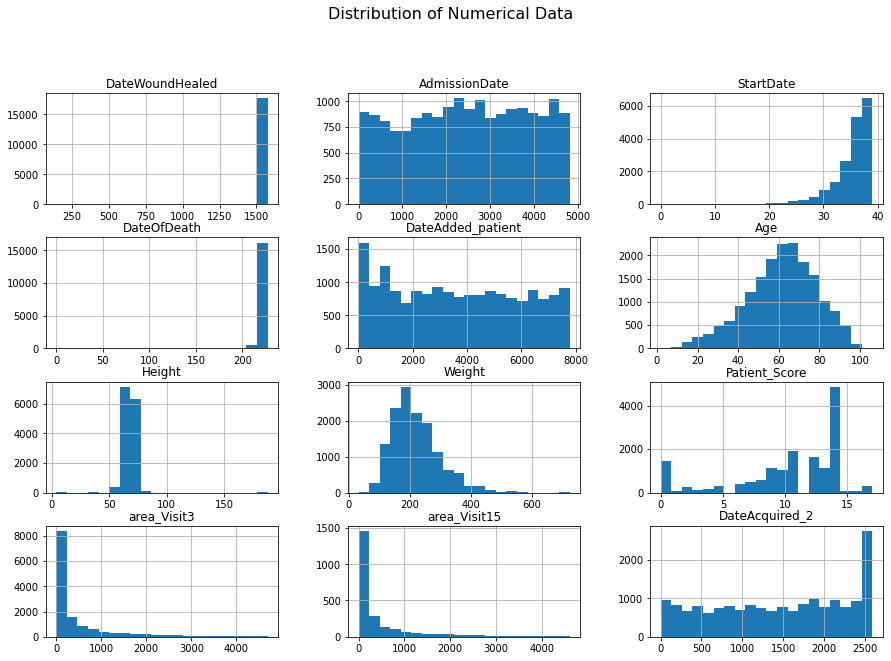

In [112]:
target_column = 'FinalVisit_Healing_Status'

# Split the data into features (X) and the target variable (y)
X = df_reduced.drop([target_column], axis=1)

# Assuming X is your DataFrame with numerical columns
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns

# Plot histograms for each numerical column
X[numerical_columns].hist(bins=20, figsize=(15, 10))
plt.suptitle('Distribution of Numerical Data', y=1, fontsize=16)
plt.show()

In [78]:
target_column = 'FinalVisit_Healing_Status'

# Split the data into features (X) and the target variable (y)
X = df_reduced.drop([target_column], axis=1)
y = df_reduced[target_column]

print("Unique values in the target variable:", y.unique())
print("Data type of the target variable:", y.dtype)
# Convert target variable to integer type
y = y.astype(int)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

X_train_resampled, y_train_resampled = X_train, y_train

# Standardize features
scaler = StandardScaler()
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Define XGBoost classifier
xgb_classifier = XGBClassifier(tree_method='gpu_hist', random_state=42)

# Set up the parameter grid for RandomizedSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1],
}
# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    xgb_classifier, param_distributions=param_grid, n_iter=10,
    scoring='accuracy', cv=5, n_jobs=-1, random_state=42
)

# Fit the model on resampled and scaled data using RandomizedSearchCV
random_search.fit(X_train_resampled_scaled, y_train_resampled)

xgb_classifier=random_search.best_estimator_

# Fit the model on resampled and scaled data
xgb_classifier.fit(X_train_resampled_scaled, y_train_resampled)

# Get feature importances
feature_importances = xgb_classifier.feature_importances_

# Create a mask for columns with importance greater than or equal to 0.005
important_columns_mask = feature_importances >= 0.005

# Get the names of the important columns
important_columns = X.columns[important_columns_mask]

# Filter X to keep only the important columns
X_filtered = X[important_columns]
X_filtered

target_column = 'FinalVisit_Healing_Status'

# Split the data into features (X) and the target variable (y)
X = X_filtered
y = df_reduced[target_column]

print("Unique values in the target variable:", y.unique())
print("Data type of the target variable:", y.dtype)
# Convert target variable to integer type
y = y.astype(int)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

X_train_resampled, y_train_resampled = X_train, y_train

# Standardize features
scaler = StandardScaler()
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Define XGBoost classifier
xgb_classifier = XGBClassifier(tree_method='gpu_hist', random_state=42)

# Set up the parameter grid for RandomizedSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1],
}
# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    xgb_classifier, param_distributions=param_grid, n_iter=10,
    scoring='accuracy', cv=5, n_jobs=-1, random_state=42
)

# Fit the model on resampled and scaled data using RandomizedSearchCV
random_search.fit(X_train_resampled_scaled, y_train_resampled)

xgb_classifier_important=random_search.best_estimator_

# Fit the model on resampled and scaled data
xgb_classifier_important.fit(X_train_resampled_scaled, y_train_resampled)

# Predict the target variable for the test set
y_pred_important = xgb_classifier_important.predict(X_test_scaled)

# Generate the classification report
report_important = classification_report(y_test, y_pred_important)
print(report_important)

# Accuracy on the test set
accuracy_important = accuracy_score(y_test, y_pred_important)
print("Test Set Accuracy (Important Features):", accuracy_important)


feature_importances = xgb_classifier_important.feature_importances_


# Get feature names
feature_names = X_filtered.columns

# Get indices that would sort feature importances in descending order
sorted_feature_indices = np.argsort(feature_importances)[::-1]

# Print the sorted feature names and importances
print("Sorted Feature Importances:")
for i, index in enumerate(sorted_feature_indices):
    feature_name = feature_names[index]
    importance_value = feature_importances[index]
    print(f"{i + 1}. Feature {feature_name}: Importance = {importance_value}")
    
# are we losing the categorical variables during feature importance?
# in gradient model, we might eliminate imp. features which are categorical variables.
# ensure the preprocessing is done correctly, check the scaling, check the feature matrix.
#try CV on XGBoost training (change the parameters in the model)
#using for loop, check the distribution of the numerical variables one by one and use scaler accordingly
#the scaling of the numerical variables should be different, not standard scaling

Unique values in the target variable: [0, 3, 2, 1]
Categories (4, int64): [0, 1, 2, 3]
Data type of the target variable: category


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

## Classification model with wound_healing_status throughout the visits

In [113]:
target_column = 'FinalVisit_Healing_Status'

# Split the data into features (X) and the target variable (y)
X = df_reduced.drop([target_column], axis=1)
y = df_reduced[target_column]

print("Unique values in the target variable:", y.unique())
print("Data type of the target variable:", y.dtype)
# Convert target variable to integer type
y = y.astype(int)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

X_train_resampled, y_train_resampled = X_train, y_train

# Standardize features
scaler = StandardScaler()
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Define XGBoost classifier
xgb_classifier = XGBClassifier(tree_method='gpu_hist', random_state=42)

# Set up the parameter grid for RandomizedSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1],
}
# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    xgb_classifier, param_distributions=param_grid, n_iter=10,
    scoring='accuracy', cv=5, n_jobs=-1, random_state=42
)

# Fit the model on resampled and scaled data using RandomizedSearchCV
random_search.fit(X_train_resampled_scaled, y_train_resampled)

xgb_classifier=random_search.best_estimator_

# Fit the model on resampled and scaled data
xgb_classifier.fit(X_train_resampled_scaled, y_train_resampled)

# Get feature importances
feature_importances = xgb_classifier.feature_importances_

# Create a mask for columns with importance greater than or equal to 0.001
important_columns_mask = feature_importances >= 0.001

# Get the names of the important columns
important_columns = X.columns[important_columns_mask]

# Filter X to keep only the important columns
X_filtered = X[important_columns]
display(X_filtered)

target_column = 'FinalVisit_Healing_Status'

# Split the data into features (X) and the target variable (y)
X = X_filtered
y = df_reduced[target_column]

print("Unique values in the target variable:", y.unique())
print("Data type of the target variable:", y.dtype)
# Convert target variable to integer type
y = y.astype(int)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Apply SMOTE to the training data
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

X_train_resampled, y_train_resampled = X_train, y_train

# Standardize features
scaler = StandardScaler()
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Define XGBoost classifier
xgb_classifier = XGBClassifier(tree_method='gpu_hist', random_state=42)

# Set up the parameter grid for RandomizedSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1],
}
# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    xgb_classifier, param_distributions=param_grid, n_iter=10,
    scoring='accuracy', cv=5, n_jobs=-1, random_state=42
)

# Fit the model on resampled and scaled data using RandomizedSearchCV
random_search.fit(X_train_resampled_scaled, y_train_resampled)

xgb_classifier_important=random_search.best_estimator_

# Fit the model on resampled and scaled data
xgb_classifier_important.fit(X_train_resampled_scaled, y_train_resampled)

# Predict the target variable for the test set
y_pred_important = xgb_classifier_important.predict(X_test_scaled)

# Generate the classification report
report_important = classification_report(y_test, y_pred_important)
print(report_important)

# Accuracy on the test set
accuracy_important = accuracy_score(y_test, y_pred_important)
print("Test Set Accuracy (Important Features):", accuracy_important)


feature_importances = xgb_classifier_important.feature_importances_


# Get feature names
feature_names = X_filtered.columns

# Get indices that would sort feature importances in descending order
sorted_feature_indices = np.argsort(feature_importances)[::-1]

# Print the sorted feature names and importances
print("Sorted Feature Importances:")
for i, index in enumerate(sorted_feature_indices):
    feature_name = feature_names[index]
    importance_value = feature_importances[index]
    print(f"{i + 1}. Feature {feature_name}: Importance = {importance_value}")
    
# are we losing the categorical variables during feature importance?. In gradient model, we might eliminate imp. features which are categorical variables.
# ensure the preprocessing is done correctly, check the scaling, check the feature matrix. (done)
#try CV on XGBoost training (change the parameters in the model) (done)
#using for loop, check the distribution of the numerical variables one by one and use scaler accordingly
#the scaling of the numerical variables should be different, not standard scaling

Unique values in the target variable: [0, 3, 2, 1]
Categories (4, int64): [0, 1, 2, 3]
Data type of the target variable: category


,DebridementLevel,IsThisBurn,BrawnyInduration_Visit1,CompCompression_Visit1,CompCompression_Visit2,Depth_Visit2,Friable_Visit2,greygran_Visit2,sinustract_Visit2,SSConfirmedLocal_Visit2,...,eschar_Visit13,Exudate_Visit14,SSConfirmedLocal_Visit14,SSSignsAndSymptoms_Visit14,SSSystemicAntibiotics_Visit14,SSXRay_Visit14,surroundingSkinColor_Visit14,TunnelingOrUndermining_Visit14,eschar_Visit14,Exudate_Visit15
0,0,1,2,1,1,9,2,2,1,0,...,16,9,2,2,2,2,6,2,16,9
1,0,1,2,1,1,12,2,2,2,0,...,16,9,2,2,2,2,6,2,16,9
2,3,3,2,1,1,5,0,2,1,0,...,16,9,2,2,2,2,6,2,16,9
3,3,3,2,1,1,9,2,2,1,0,...,16,9,2,2,2,2,6,2,16,9
4,0,1,2,1,1,19,2,2,1,0,...,16,9,2,2,2,2,6,2,16,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17700,3,3,2,0,0,0,2,2,1,0,...,16,9,2,2,2,2,6,2,16,9
17701,3,3,2,0,0,0,2,2,2,0,...,16,9,2,2,2,2,6,2,16,9
17702,0,1,2,1,1,12,2,2,2,0,...,16,9,2,2,2,2,6,2,16,9
17703,0,1,2,1,1,5,2,2,1,0,...,16,9,2,2,2,2,6,2,16,9


Unique values in the target variable: [0, 3, 2, 1]
Categories (4, int64): [0, 1, 2, 3]
Data type of the target variable: category
              precision    recall  f1-score   support

           0       0.96      0.85      0.90       457
           1       0.93      0.89      0.91      1161
           2       0.98      0.87      0.92       521
           3       0.86      0.95      0.90      1402

    accuracy                           0.91      3541
   macro avg       0.93      0.89      0.91      3541
weighted avg       0.91      0.91      0.91      3541

Test Set Accuracy (Important Features): 0.9070883931092911
Sorted Feature Importances:
1. Feature TunnelingOrUndermining_Visit4: Importance = 0.08258965611457825
2. Feature TunnelingOrUndermining_Visit3: Importance = 0.056718967854976654
3. Feature AdiposeExposed_Visit3: Importance = 0.03908868134021759
4. Feature SSConfirmedLocal_Visit3: Importance = 0.035830333828926086
5. Feature AdiposeExposed_Visit4: Importance = 0.03076318651

In [115]:
data = """
1. Feature TunnelingOrUndermining_Visit4: Importance = 0.08258965611457825
2. Feature TunnelingOrUndermining_Visit3: Importance = 0.056718967854976654
3. Feature AdiposeExposed_Visit3: Importance = 0.03908868134021759
4. Feature SSConfirmedLocal_Visit3: Importance = 0.035830333828926086
5. Feature AdiposeExposed_Visit4: Importance = 0.030763186514377594
6. Feature TunnelingOrUndermining_Visit5: Importance = 0.027844086289405823
7. Feature SSXRay_Visit5: Importance = 0.02642720192670822
8. Feature CompCompression_Visit5: Importance = 0.020294154062867165
9. Feature eschar_Visit3: Importance = 0.019936515018343925
10. Feature SSXRay_Visit3: Importance = 0.01848897896707058
11. Feature Wound_healing_status_Visit2: Importance = 0.01832801103591919
12. Feature CompCompression_Visit4: Importance = 0.017121948301792145
13. Feature SSConfirmedLocal_Visit6: Importance = 0.01655166782438755
14. Feature eschar_Visit4: Importance = 0.014414612203836441
15. Feature SSXRay_Visit6: Importance = 0.013227217830717564
16. Feature TunnelingOrUndermining_Visit6: Importance = 0.012581388466060162
17. Feature SSSystemicAntibiotics_Visit5: Importance = 0.011139907874166965
18. Feature SSXRay_Visit4: Importance = 0.010993595235049725
19. Feature SSXRay_Visit12: Importance = 0.010690811090171337
20. Feature SSConfirmedLocal_Visit8: Importance = 0.010540156625211239
21. Feature AdiposeExposed_Visit5: Importance = 0.010385366156697273
22. Feature SSConfirmedLocal_Visit7: Importance = 0.009911906905472279
23. Feature SSXRay_Visit7: Importance = 0.00980410911142826
24. Feature CompCompression_Visit6: Importance = 0.009533691219985485
25. Feature CompCompression_Visit9: Importance = 0.008951210416853428
26. Feature Wound_healing_status_Visit3: Importance = 0.008777853101491928
27. Feature AdiposeExposed_Visit7: Importance = 0.008194559253752232
28. Feature TunnelingOrUndermining_Visit7: Importance = 0.007887438870966434
29. Feature SSXRay_Visit11: Importance = 0.007825732231140137
30. Feature SSSystemicAntibiotics_Visit4: Importance = 0.007607926148921251
31. Feature eschar_Visit7: Importance = 0.007331108208745718
32. Feature SSConfirmedLocal_Visit4: Importance = 0.007328724022954702
33. Feature Exudate_Visit5: Importance = 0.007090653292834759
34. Feature AdiposeExposed_Visit6: Importance = 0.007076691370457411
35. Feature SSConfirmedLocal_Visit9: Importance = 0.00663260230794549
36. Feature Wound_healing_status_Visit4: Importance = 0.006606774404644966
37. Feature SSSystemicAntibiotics_Visit8: Importance = 0.006577951833605766
38. Feature eschar_Visit5: Importance = 0.006384834181517363
39. Feature NoMeasurableDepth_Visit4: Importance = 0.006329407915472984
40. Feature NoMeasurableDepth_Visit5: Importance = 0.0063257599249482155
41. Feature Exudate_Visit4: Importance = 0.0062448917888104916
42. Feature Depth_Visit2: Importance = 0.006028842646628618
43. Feature AdiposeExposed_Visit8: Importance = 0.005573662463575602
44. Feature tunneling_Visit2: Importance = 0.005529611371457577
45. Feature SSXRay_Visit8: Importance = 0.0053346361964941025
46. Feature TunnelingOrUndermining_Visit8: Importance = 0.005027074366807938
47. Feature eschar_Visit8: Importance = 0.004986800253391266
48. Feature CompCompression_Visit8: Importance = 0.004886453039944172
49. Feature SSSystemicAntibiotics_Visit6: Importance = 0.004816505592316389
50. Feature Exudate_Visit3: Importance = 0.004780920688062906
51. Feature SSSignsAndSymptoms_Visit10: Importance = 0.004773796070367098
52. Feature Depth_Visit4: Importance = 0.00476023880764842
53. Feature Wound_healing_status_Visit5: Importance = 0.004737140145152807
54. Feature eschar_Visit6: Importance = 0.004617216065526009
55. Feature CompCompression_Visit7: Importance = 0.004611510317772627
56. Feature Depth_Visit5: Importance = 0.004587271250784397
57. Feature SSSignsAndSymptoms_Visit7: Importance = 0.004263545852154493
58. Feature eschar_Visit10: Importance = 0.00412503257393837
59. Feature DebridementLevel: Importance = 0.004079511854797602
60. Feature SSSystemicAntibiotics_Visit10: Importance = 0.003999936394393444
61. Feature TunnelingOrUndermining_Visit9: Importance = 0.003976534586399794
62. Feature Exudate_Visit6: Importance = 0.00392680149525404
63. Feature NoMeasurableDepth_Visit6: Importance = 0.003800479229539633
64. Feature tunneling_Visit5: Importance = 0.0037914125714451075
65. Feature area_Visit3: Importance = 0.0037358764093369246
66. Feature AdiposeNecrosisExposed_Visit6: Importance = 0.0036299689672887325
67. Feature TunnelingOrUndermining_Visit10: Importance = 0.003578350180760026
68. Feature woundProgress_Visit4: Importance = 0.0033732482697814703
69. Feature Exudate_Visit7: Importance = 0.0033366940915584564
70. Feature Pain_Visit8: Importance = 0.0032926180865615606
71. Feature WoundMargin_Visit7: Importance = 0.003274306422099471
72. Feature CompCompression_Visit3: Importance = 0.003236518707126379
73. Feature SSConfirmedLocal_Visit10: Importance = 0.003227474633604288
74. Feature Wound_healing_status_Visit6: Importance = 0.0032226780895143747
75. Feature Pain_Visit10: Importance = 0.003220554906874895
76. Feature Depth_Visit8: Importance = 0.00319879618473351
77. Feature Wound_healing_status_Visit7: Importance = 0.003137439489364624
78. Feature sinustract_Visit6: Importance = 0.003117447020485997
79. Feature Depth_Visit6: Importance = 0.003093357663601637
80. Feature SSSystemicAntibiotics_Visit7: Importance = 0.003090155078098178
81. Feature tunneling_Visit6: Importance = 0.0030428869649767876
82. Feature Depth_Visit7: Importance = 0.0030423232819885015
83. Feature Pain_Visit9: Importance = 0.00299305422231555
84. Feature SSConfirmedLocal_Visit11: Importance = 0.0029883920215070248
85. Feature SSSignsAndSymptoms_Visit4: Importance = 0.002975311130285263
86. Feature Pain_Visit5: Importance = 0.002934540156275034
87. Feature SSSignsAndSymptoms_Visit5: Importance = 0.002848280593752861
88. Feature SSSignsAndSymptoms_Visit6: Importance = 0.002834117505699396
89. Feature NoMeasurableDepth_Visit7: Importance = 0.0027579942252486944
90. Feature Wound_healing_status_Visit8: Importance = 0.002753026783466339
91. Feature woundProgress_Visit3: Importance = 0.0027527844067662954
92. Feature IsThisBurn: Importance = 0.002744528464972973
93. Feature eschar_Visit9: Importance = 0.0027056129183620214
94. Feature SSSignsAndSymptoms_Visit8: Importance = 0.0026158716063946486
95. Feature Pain_Visit6: Importance = 0.002492903033271432
96. Feature SSSystemicAntibiotics_Visit9: Importance = 0.0024920084979385138
97. Feature ExudateAmount_Visit6: Importance = 0.0024015859235078096
98. Feature CompCompression_Visit12: Importance = 0.002386565087363124
99. Feature WoundMargin_Visit9: Importance = 0.0023352238349616528
100. Feature Wound_healing_status_Visit10: Importance = 0.0023148232139647007
101. Feature WoundMargin_Visit8: Importance = 0.0022923785727471113
102. Feature WoundMargin_Visit4: Importance = 0.002276047132909298
103. Feature Exudate_Visit8: Importance = 0.002239687368273735
104. Feature woundProgress_Visit6: Importance = 0.0021586210932582617
105. Feature Wound_healing_status_Visit9: Importance = 0.002144378377124667
106. Feature SSConfirmedLocal_Visit5: Importance = 0.0021257211919873953
107. Feature AdiposeExposed_Visit11: Importance = 0.0021198473405092955
108. Feature sinustract_Visit3: Importance = 0.002083743689581752
109. Feature AdiposeExposed_Visit10: Importance = 0.0020746008958667517
110. Feature Depth_Visit9: Importance = 0.002012341981753707
111. Feature WoundMargin_Visit6: Importance = 0.0020017256028950214
112. Feature SSSignsAndSymptoms_Visit11: Importance = 0.001999686937779188
113. Feature WoundMargin_Visit11: Importance = 0.0019890868570655584
114. Feature sinustract_Visit8: Importance = 0.001983321737498045
115. Feature Pain_Visit11: Importance = 0.0019748492632061243
116. Feature Depth_Visit3: Importance = 0.0019373237155377865
117. Feature Depth_Visit11: Importance = 0.0018826877931132913
118. Feature CompCompression_Visit1: Importance = 0.0018660309724509716
119. Feature SSSystemicAntibiotics_Visit3: Importance = 0.0018608405953273177
120. Feature Wound_healing_status_Visit11: Importance = 0.0018578097224235535
121. Feature Exudate_Visit9: Importance = 0.0018553681438788772
122. Feature slough_Visit4: Importance = 0.0018475190736353397
123. Feature ExudateAmount_Visit5: Importance = 0.0018409977201372385
124. Feature eschar_Visit12: Importance = 0.0018098670989274979
125. Feature eschar_Visit11: Importance = 0.0018034318927675486
126. Feature tunneling_Visit4: Importance = 0.0017688845982775092
127. Feature Pain_Visit4: Importance = 0.001763730775564909
128. Feature SSSystemicAntibiotics_Visit11: Importance = 0.0017629626672714949
129. Feature Pain_Visit7: Importance = 0.0017352350987493992
130. Feature Depth_Visit10: Importance = 0.0016744571039453149
131. Feature slough_Visit6: Importance = 0.001614935346879065
132. Feature SSSignsAndSymptoms_Visit9: Importance = 0.0015378041425719857
133. Feature BrawnyInduration_Visit1: Importance = 0.0015338246012106538
134. Feature WoundMargin_Visit5: Importance = 0.0015323596308007836
135. Feature slough_Visit5: Importance = 0.001519997138530016
136. Feature Temperature_Visit11: Importance = 0.0015139137394726276
137. Feature SSSystemicAntibiotics_Visit13: Importance = 0.0014840929070487618
138. Feature woundProgress_Visit5: Importance = 0.0014366869581863284
139. Feature SystematicInfection_Visit9: Importance = 0.0014365267707034945
140. Feature WoundMargin_Visit10: Importance = 0.0014329461846500635
141. Feature ExudateAmount_Visit4: Importance = 0.0014207263011485338
142. Feature eschar_Visit13: Importance = 0.0014155172975733876
143. Feature Depth_Visit12: Importance = 0.0014023176627233624
144. Feature NoMeasurableDepth_Visit8: Importance = 0.0013992231106385589
145. Feature Pain_Visit12: Importance = 0.0013989838771522045
146. Feature AdiposeExposed_Visit12: Importance = 0.0013718688860535622
147. Feature CompCompression_Visit11: Importance = 0.0013646301813423634
148. Feature SystematicInfection_Visit5: Importance = 0.0013419989263638854
149. Feature ExudateAmount_Visit8: Importance = 0.0012860344722867012
150. Feature slough_Visit7: Importance = 0.0012746092397719622
151. Feature SystematicInfection_Visit10: Importance = 0.0012631607241928577
152. Feature woundProgress_Visit12: Importance = 0.0012505952036008239
153. Feature Pain_Visit3: Importance = 0.0012227912666276097
154. Feature WoundMargin_Visit12: Importance = 0.0012173800496384501
155. Feature sinustract_Visit7: Importance = 0.0011813772143796086
156. Feature Exudate_Visit14: Importance = 0.0011763444636017084
157. Feature TunnelingOrUndermining_Visit14: Importance = 0.0011701008770614862
158. Feature Callus_Visit7: Importance = 0.0011662633623927832
159. Feature ExudateAmount_Visit9: Importance = 0.0011573624797165394
160. Feature WoundMargin_Visit3: Importance = 0.001146665308624506
161. Feature CompCompression_Visit13: Importance = 0.0011304906802251935
162. Feature Exudate_Visit12: Importance = 0.0011238240404054523
163. Feature Stage_Visit5: Importance = 0.0010908469557762146
164. Feature Rubor_Visit4: Importance = 0.0010898747714236379
165. Feature SSSystemicAntibiotics_Visit14: Importance = 0.0010642686393111944
166. Feature greygran_Visit2: Importance = 0.0010587949072942138
167. Feature slough_Visit13: Importance = 0.001047106459736824
168. Feature Odor_Visit8: Importance = 0.0010429269168525934
169. Feature Stage_Visit7: Importance = 0.0010401041945442557
170. Feature surroundingSkin_Visit11: Importance = 0.0010283326264470816
171. Feature SSSignsAndSymptoms_Visit14: Importance = 0.0010267305187880993
172. Feature BrawnyInduration_Visit10: Importance = 0.0010067360708490014
173. Feature eschar_Visit14: Importance = 0.0010020047193393111
174. Feature Exudate_Visit15: Importance = 0.000998524483293295
175. Feature sinustract_Visit2: Importance = 0.0009816661477088928
176. Feature SystematicInfection_Visit8: Importance = 0.000978494412265718
177. Feature SSXRay_Visit14: Importance = 0.0009645557729527354
178. Feature Scarring_Visit4: Importance = 0.0009643240482546389
179. Feature SSConfirmedLocal_Visit13: Importance = 0.0009338339441455901
180. Feature Denuded_Visit5: Importance = 0.0009328333544544876
181. Feature SSSignsAndSymptoms_Visit13: Importance = 0.0009315149509347975
182. Feature color_Visit3: Importance = 0.0009311283938586712
183. Feature normalTexture_Visit13: Importance = 0.0008949053008109331
184. Feature SSSignsAndSymptoms_Visit12: Importance = 0.000872055534273386
185. Feature AdiposeExposed_Visit13: Importance = 0.0008483663550578058
186. Feature BrawnyInduration_Visit5: Importance = 0.0008101076236926019
187. Feature surroundingSkinColor_Visit14: Importance = 0.0007890700944699347
188. Feature Shiny_Visit3: Importance = 0.0007545332773588598
189. Feature SSConfirmedLocal_Visit2: Importance = 0.0006798662361688912
190. Feature Friable_Visit2: Importance = 0.0006535916472785175
191. Feature TunnelingOrUndermining_Visit13: Importance = 0.0005934967193752527
192. Feature SSConfirmedLocal_Visit14: Importance = 0.0005708347889594734
193. Feature SSSystemicAntibiotics_Visit12: Importance = 0.00017748642130754888
194. Feature CompCompression_Visit2: Importance = 0.0
"""
    
    
# Define a regular expression pattern to extract features and importance values
pattern = re.compile(r'(\d+)\. Feature (\S+): Importance = ([\d.]+)')

# Find all matches in the data
matches = pattern.findall(data)

# Create a list of tuples with the desired format
feature_importances = [(match[1], float(match[2])) for match in matches] 

feature_importances

# Create a dictionary to store the summed importance values for each prefix
summed_importances = defaultdict(float)

# Sum up the importance values for features with the same prefix
for feature, importance in feature_importances:
    prefix = feature.split('_Visit')[0]  # Extract the prefix (e.g., "TunnelingOrUndermining")
    summed_importances[prefix] += importance

# Display the summed importance values
print("Summed Importance Values:")
for prefix, summed_importance in summed_importances.items():
    print(f"{prefix}: {round(summed_importance, 4)}")
    

total_importance = sum(summed_importances.values())
total_importance

# Sort the summed_importances dictionary based on values in descending order
sorted_summed_importances = dict(sorted(summed_importances.items(), key=lambda item: item[1], reverse=True))

# Display the sorted summed_importances values
print("Sorted Summed Importance Values (Highest to Lowest):")
for prefix, summed_importance in sorted_summed_importances.items():
    print(f"{prefix}: {round(summed_importance, 4)}")

Summed Importance Values:
TunnelingOrUndermining: 0.202
AdiposeExposed: 0.1075
SSConfirmedLocal: 0.0973
SSXRay: 0.1038
CompCompression: 0.0754
eschar: 0.0705
Wound_healing_status: 0.0539
SSSystemicAntibiotics: 0.0461
Exudate: 0.0328
NoMeasurableDepth: 0.0206
Depth: 0.0336
tunneling: 0.0141
SSSignsAndSymptoms: 0.0267
DebridementLevel: 0.0041
area: 0.0037
AdiposeNecrosisExposed: 0.0036
woundProgress: 0.011
Pain: 0.023
WoundMargin: 0.0195
sinustract: 0.0093
IsThisBurn: 0.0027
ExudateAmount: 0.0081
slough: 0.0073
BrawnyInduration: 0.0034
Temperature: 0.0015
SystematicInfection: 0.005
Callus: 0.0012
Stage: 0.0021
Rubor: 0.0011
greygran: 0.0011
Odor: 0.001
surroundingSkin: 0.001
Scarring: 0.001
Denuded: 0.0009
color: 0.0009
normalTexture: 0.0009
surroundingSkinColor: 0.0008
Shiny: 0.0008
Friable: 0.0007
Sorted Summed Importance Values (Highest to Lowest):
TunnelingOrUndermining: 0.202
AdiposeExposed: 0.1075
SSXRay: 0.1038
SSConfirmedLocal: 0.0973
CompCompression: 0.0754
eschar: 0.0705
Wound_

## Classification model without wound_healing_status throughout the visits

In [130]:
target_column = 'FinalVisit_Healing_Status'

# Split the data into features (X) and the target variable (y)
X = df_reduced.drop([target_column, 'Wound_healing_status_Visit1', 'Wound_healing_status_Visit2', 'Wound_healing_status_Visit3', 'Wound_healing_status_Visit4', 
                     'Wound_healing_status_Visit5', 'Wound_healing_status_Visit6', 'Wound_healing_status_Visit7',
                     'Wound_healing_status_Visit8', 'Wound_healing_status_Visit9', 'Wound_healing_status_Visit10',
                     'Wound_healing_status_Visit11', 'Wound_healing_status_Visit12', 'Wound_healing_status_Visit13', 
                     'Wound_healing_status_Visit14', 'Wound_healing_status_Visit15'], axis=1)
y = df_reduced[target_column]

print("Unique values in the target variable:", y.unique())
print("Data type of the target variable:", y.dtype)
# Convert target variable to integer type
y = y.astype(int)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

X_train_resampled, y_train_resampled = X_train, y_train

# Standardize features
scaler = StandardScaler()
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Define XGBoost classifier
xgb_classifier = XGBClassifier(tree_method='gpu_hist', random_state=42)

# Set up the parameter grid for RandomizedSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1],
}
# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    xgb_classifier, param_distributions=param_grid, n_iter=10,
    scoring='accuracy', cv=5, n_jobs=-1, random_state=42
)

# Fit the model on resampled and scaled data using RandomizedSearchCV
random_search.fit(X_train_resampled_scaled, y_train_resampled)

xgb_classifier=random_search.best_estimator_

# Fit the model on resampled and scaled data
xgb_classifier.fit(X_train_resampled_scaled, y_train_resampled)

# Get feature importances
feature_importances = xgb_classifier.feature_importances_

# Create a mask for columns with importance greater than or equal to 0.0
important_columns_mask = feature_importances > 0

# Get the names of the important columns
important_columns = X.columns[important_columns_mask]

# Filter X to keep only the important columns
X_filtered = X[important_columns]
display(X_filtered)

target_column = 'FinalVisit_Healing_Status'

# Split the data into features (X) and the target variable (y)
X = X_filtered
y = df_reduced[target_column]

print("Unique values in the target variable:", y.unique())
print("Data type of the target variable:", y.dtype)
# Convert target variable to integer type
y = y.astype(int)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Apply SMOTE to the training data
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

X_train_resampled, y_train_resampled = X_train, y_train

# Standardize features
scaler = StandardScaler()
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Define XGBoost classifier
xgb_classifier = XGBClassifier(tree_method='gpu_hist', random_state=42)

# Set up the parameter grid for RandomizedSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1],
}
# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    xgb_classifier, param_distributions=param_grid, n_iter=10,
    scoring='accuracy', cv=5, n_jobs=-1, random_state=42
)

# Fit the model on resampled and scaled data using RandomizedSearchCV
random_search.fit(X_train_resampled_scaled, y_train_resampled)

xgb_classifier_important=random_search.best_estimator_

# Fit the model on resampled and scaled data
xgb_classifier_important.fit(X_train_resampled_scaled, y_train_resampled)

# Predict the target variable for the test set
y_pred_important = xgb_classifier_important.predict(X_test_scaled)

# Generate the classification report
report_important = classification_report(y_test, y_pred_important)
print(report_important)

# Accuracy on the test set
accuracy_important = accuracy_score(y_test, y_pred_important)
print("Test Set Accuracy (Important Features):", accuracy_important)


feature_importances = xgb_classifier_important.feature_importances_


# Get feature names
feature_names = X_filtered.columns

# Get indices that would sort feature importances in descending order
sorted_feature_indices = np.argsort(feature_importances)[::-1]

# Print the sorted feature names and importances
print("Sorted Feature Importances:")
for i, index in enumerate(sorted_feature_indices):
    feature_name = feature_names[index]
    importance_value = feature_importances[index]
    print(f"{i + 1}. Feature {feature_name}: Importance = {importance_value}")
    
# are we losing the categorical variables during feature importance?. In gradient model, we might eliminate imp. features which are categorical variables.
# ensure the preprocessing is done correctly, check the scaling, check the feature matrix. (done)
#try CV on XGBoost training (change the parameters in the model) (done)
#using for loop, check the distribution of the numerical variables one by one and use scaler accordingly
#the scaling of the numerical variables should be different, not standard scaling

Unique values in the target variable: [0, 3, 2, 1]
Categories (4, int64): [0, 1, 2, 3]
Data type of the target variable: category


,AccidentType,Anterior_Posterior,Anterior_Dorsal,DateWoundHealed,Inferior_Superior,Left_Right,Location,Proximal_Distal,ResolvedRecurrence,ResultOfAccident,...,surroundingSkin_Visit15,surroundingSkinColor_Visit15,SystematicInfection_Visit15,TendonNecrosisExposed_Visit15,tunneling_Visit15,woundProgress_Visit15,GranulationTexture_Visit15,WoundMargin_Visit15,eschar_Visit15,DateAcquired_2
0,0,0,2,1576,2,1,14,2,2,2,...,5,7,3,3,4,5,4,11,16,437
1,0,2,1,1576,2,1,28,2,1,2,...,5,7,3,3,4,5,4,11,16,2420
2,0,2,1,1576,1,2,28,2,1,1,...,5,7,3,3,4,5,4,11,16,452
3,0,2,2,1576,2,1,28,2,1,1,...,5,7,3,3,4,5,4,11,16,904
4,0,2,2,1576,2,1,15,2,2,2,...,5,7,3,3,4,5,4,11,16,2483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17700,0,2,2,1576,2,0,23,2,1,1,...,5,7,3,3,4,5,4,11,16,2420
17701,0,2,2,1576,2,0,76,2,1,1,...,5,7,3,3,4,5,4,11,16,262
17702,0,0,2,1576,2,0,14,2,2,2,...,5,7,3,3,4,5,4,11,16,248
17703,0,0,2,1576,2,0,14,2,2,2,...,5,7,3,3,4,5,4,11,16,248


Unique values in the target variable: [0, 3, 2, 1]
Categories (4, int64): [0, 1, 2, 3]
Data type of the target variable: category
              precision    recall  f1-score   support

           0       0.24      0.08      0.12       457
           1       0.76      0.83      0.79      1161
           2       0.41      0.26      0.32       521
           3       0.59      0.76      0.66      1402

    accuracy                           0.62      3541
   macro avg       0.50      0.48      0.47      3541
weighted avg       0.58      0.62      0.59      3541

Test Set Accuracy (Important Features): 0.6201637955379836
Sorted Feature Importances:
1. Feature TunnelingOrUndermining_Visit4: Importance = 0.09180378913879395
2. Feature TunnelingOrUndermining_Visit5: Importance = 0.030375830829143524
3. Feature TunnelingOrUndermining_Visit7: Importance = 0.01825026609003544
4. Feature CompCompression_Visit5: Importance = 0.014934717677533627
5. Feature TunnelingOrUndermining_Visit6: Importance 

In [131]:
data = """
1. Feature TunnelingOrUndermining_Visit4: Importance = 0.09180378913879395
2. Feature TunnelingOrUndermining_Visit5: Importance = 0.030375830829143524
3. Feature TunnelingOrUndermining_Visit7: Importance = 0.01825026609003544
4. Feature CompCompression_Visit5: Importance = 0.014934717677533627
5. Feature TunnelingOrUndermining_Visit6: Importance = 0.013758073560893536
6. Feature TunnelingOrUndermining_Visit11: Importance = 0.013729934580624104
7. Feature CompCompression_Visit4: Importance = 0.013704361394047737
8. Feature TunnelingOrUndermining_Visit2: Importance = 0.012777499854564667
9. Feature eschar_Visit12: Importance = 0.010023594833910465
10. Feature SSConfirmedLocal_Visit3: Importance = 0.009812002070248127
11. Feature SSConfirmedLocal_Visit4: Importance = 0.008645081892609596
12. Feature SSXRay_Visit5: Importance = 0.008500355295836926
13. Feature Exudate_Visit14: Importance = 0.007911005057394505
14. Feature eschar_Visit4: Importance = 0.007813871838152409
15. Feature SSSystemicAntibiotics_Visit4: Importance = 0.007733012083917856
16. Feature eschar_Visit15: Importance = 0.00643044151365757
17. Feature tunneling_Visit2: Importance = 0.006346289999783039
18. Feature Depth_Visit2: Importance = 0.00616850471124053
19. Feature CompCompression_Visit7: Importance = 0.005779679398983717
20. Feature SSSystemicAntibiotics_Visit5: Importance = 0.005742568522691727
21. Feature CompCompression_Visit2: Importance = 0.005383037030696869
22. Feature eschar_Visit9: Importance = 0.004837046377360821
23. Feature woundProgress_Visit6: Importance = 0.004462053067982197
24. Feature woundProgress_Visit13: Importance = 0.003976692911237478
25. Feature Depth_Visit4: Importance = 0.003967633005231619
26. Feature Depth_Visit5: Importance = 0.003881020238623023
27. Feature Exudate_Visit9: Importance = 0.003817174816504121
28. Feature SSSignsAndSymptoms_Visit4: Importance = 0.0036778985522687435
29. Feature woundProgress_Visit11: Importance = 0.00363917020149529
30. Feature SSSystemicAntibiotics_Visit8: Importance = 0.003594272071495652
31. Feature eschar_Visit14: Importance = 0.003455069847404957
32. Feature slough_Visit3: Importance = 0.0031510074622929096
33. Feature woundProgress_Visit4: Importance = 0.003115388797596097
34. Feature ExudateAmount_Visit14: Importance = 0.003020646283403039
35. Feature tunneling_Visit5: Importance = 0.0029628330375999212
36. Feature Induration_Visit5: Importance = 0.002960951765999198
37. Feature DebridementLevel: Importance = 0.002947250148281455
38. Feature AdiposeExposed_Visit4: Importance = 0.002852651523426175
39. Feature IsThisBurn: Importance = 0.0028347873594611883
40. Feature eschar_Visit6: Importance = 0.0028167685959488153
41. Feature Depth_Visit6: Importance = 0.0027955551631748676
42. Feature Induration_Visit9: Importance = 0.0027458807453513145
43. Feature NoMeasurableDepth_Visit6: Importance = 0.0026982624549418688
44. Feature CompCompression_Visit13: Importance = 0.0026480876840651035
45. Feature area_Visit3: Importance = 0.002577853389084339
46. Feature eschar_Visit8: Importance = 0.002502818126231432
47. Feature Depth_Visit8: Importance = 0.0024869635235518217
48. Feature surroundingSkin_Visit9: Importance = 0.002475700108334422
49. Feature SSSystemicAntibiotics_Visit7: Importance = 0.0024648706894367933
50. Feature SSXRay_Visit4: Importance = 0.0024448877666145563
51. Feature TunnelingOrUndermining_Visit3: Importance = 0.0024433264043182135
52. Feature SSSystemicAntibiotics_Visit6: Importance = 0.0024078574497252703
53. Feature Callus_Visit2: Importance = 0.0024077778216451406
54. Feature SSXRay_Visit10: Importance = 0.0023507468868047
55. Feature Exudate_Visit7: Importance = 0.002333668991923332
56. Feature Denuded_Visit10: Importance = 0.002321577165275812
57. Feature eschar_Visit2: Importance = 0.0023050718009471893
58. Feature Depth_Visit9: Importance = 0.0022857780568301678
59. Feature Depth_Visit10: Importance = 0.0022846870124340057
60. Feature greygran_Visit8: Importance = 0.0022669974714517593
61. Feature eschar_Visit7: Importance = 0.002251999918371439
62. Feature eschar_Visit5: Importance = 0.0021822864655405283
63. Feature NoMeasurableDepth_Visit7: Importance = 0.002167197410017252
64. Feature Depth_Visit7: Importance = 0.002139731775969267
65. Feature woundProgress_Visit2: Importance = 0.0021335117053240538
66. Feature Depth_Visit11: Importance = 0.002125777304172516
67. Feature Pain_Visit11: Importance = 0.0021175493020564318
68. Feature Depth_Visit1: Importance = 0.002102450467646122
69. Feature Callus_Visit4: Importance = 0.002102149650454521
70. Feature CompCompression_Visit1: Importance = 0.0020294974092394114
71. Feature TendonNecrosisExposed_Visit9: Importance = 0.0020021197851747274
72. Feature Exudate_Visit8: Importance = 0.0019309570780023932
73. Feature SSConfirmedLocal_Visit5: Importance = 0.0019223764538764954
74. Feature surroundingSkin_Visit14: Importance = 0.0019070045091211796
75. Feature Denuded_Visit8: Importance = 0.0019008355448022485
76. Feature CompCompression_Visit8: Importance = 0.0018856532406061888
77. Feature Maceration_Visit9: Importance = 0.0018851287895813584
78. Feature Odor_Visit15: Importance = 0.0018814877839758992
79. Feature surroundingSkin_Visit13: Importance = 0.0018617331515997648
80. Feature WoundMargin_Visit7: Importance = 0.0018347870791330934
81. Feature sinustract_Visit8: Importance = 0.0018257598858326674
82. Feature Odor_Visit9: Importance = 0.0018245759420096874
83. Feature Induration_Visit14: Importance = 0.0018232783768326044
84. Feature TendonNecrosisExposed_Visit7: Importance = 0.0018156531732529402
85. Feature AdiposeExposed_Visit6: Importance = 0.0018147658556699753
86. Feature SSConfirmedLocal_Visit2: Importance = 0.0017852375749498606
87. Feature Rash_Visit8: Importance = 0.0017451352905482054
88. Feature Exudate_Visit4: Importance = 0.0017404708778485656
89. Feature Erythema_Visit15: Importance = 0.0017346566310152411
90. Feature eschar_Visit13: Importance = 0.0017209653742611408
91. Feature Hemosiderosis_Visit6: Importance = 0.0017093680799007416
92. Feature surroundingSkinColor_Visit9: Importance = 0.001684002229012549
93. Feature Denuded_Visit7: Importance = 0.0016574034234508872
94. Feature eschar_Visit11: Importance = 0.0016502825310453773
95. Feature Exudate_Visit5: Importance = 0.001649313373491168
96. Feature surroundingSkin_Visit11: Importance = 0.0016029438702389598
97. Feature sinustract_Visit9: Importance = 0.0015938559081405401
98. Feature SSSystemicAntibiotics_Visit15: Importance = 0.0015884749591350555
99. Feature Pain_Visit6: Importance = 0.0015670056454837322
100. Feature Stage_Visit13: Importance = 0.0015596356242895126
101. Feature Depth_Visit12: Importance = 0.0015176570741459727
102. Feature Shiny_Visit1: Importance = 0.0014950159238651395
103. Feature NoMeasurableDepth_Visit2: Importance = 0.001494766678661108
104. Feature Maceration_Visit10: Importance = 0.0014936088118702173
105. Feature GranulationTexture_Visit5: Importance = 0.0014866425190120935
106. Feature NoMeasurableDepth_Visit10: Importance = 0.0014810803113505244
107. Feature Edema_Visit13: Importance = 0.0014792345464229584
108. Feature surroundingSkin_Visit4: Importance = 0.0014690933749079704
109. Feature Hemosiderosis_Visit14: Importance = 0.0014551285421475768
110. Feature Friable_Visit4: Importance = 0.0014421857194975019
111. Feature WoundMargin_Visit3: Importance = 0.001437614788301289
112. Feature Callus_Visit13: Importance = 0.0014339705230668187
113. Feature Depth_Visit13: Importance = 0.0014326205709949136
114. Feature tunneling_Visit1: Importance = 0.0014279612805694342
115. Feature BrawnyInduration_Visit1: Importance = 0.0014243758050724864
116. Feature DryScaly_Visit7: Importance = 0.0014236281858757138
117. Feature AdiposeExposed_Visit5: Importance = 0.0014081933768466115
118. Feature area_Visit15: Importance = 0.0014077873202040792
119. Feature Depth_Visit3: Importance = 0.0014008615398779511
120. Feature Depth_Visit14: Importance = 0.0013978432398289442
121. Feature woundProgress_Visit5: Importance = 0.0013964003883302212
122. Feature AdiposeExposed_Visit3: Importance = 0.0013840660685673356
123. Feature Friable_Visit3: Importance = 0.0013786278432235122
124. Feature sinustract_Visit1: Importance = 0.0013699273113161325
125. Feature normalTexture_Visit8: Importance = 0.001365262782201171
126. Feature Maceration_Visit14: Importance = 0.0013648142339661717
127. Feature NormalMoisture_Visit13: Importance = 0.0013618561206385493
128. Feature redgran_Visit5: Importance = 0.0013517983024939895
129. Feature woundProgress_Visit3: Importance = 0.0013509736163541675
130. Feature CompCompression_Visit3: Importance = 0.0013486141106113791
131. Feature Scarring_Visit7: Importance = 0.0013472620630636811
132. Feature surroundingSkinColor_Visit4: Importance = 0.001338058733381331
133. Feature AdiposeExposed_Visit8: Importance = 0.0013270624913275242
134. Feature Odor_Visit6: Importance = 0.0013247933238744736
135. Feature Edema_Visit8: Importance = 0.0013202440459281206
136. Feature surroundingSkinColor_Visit6: Importance = 0.00130767235532403
137. Feature color_Visit13: Importance = 0.001307235797867179
138. Feature AdiposeExposed_Visit2: Importance = 0.0013046301901340485
139. Feature redgran_Visit13: Importance = 0.001293722540140152
140. Feature Rash_Visit11: Importance = 0.0012923741014674306
141. Feature DryScaly_Visit9: Importance = 0.0012904687318950891
142. Feature Odor_Visit1: Importance = 0.0012878882698714733
143. Feature Callus_Visit14: Importance = 0.0012862299336120486
144. Feature slough_Visit4: Importance = 0.0012809501495212317
145. Feature Pain_Visit3: Importance = 0.0012798645766451955
146. Feature WoundMargin_Visit10: Importance = 0.0012775745708495378
147. Feature Induration_Visit7: Importance = 0.0012772097252309322
148. Feature Maceration_Visit7: Importance = 0.0012757779331877828
149. Feature GranulationTexture_Visit9: Importance = 0.001270556589588523
150. Feature redgran_Visit12: Importance = 0.001268348190933466
151. Feature WoundMargin_Visit8: Importance = 0.0012640167260542512
152. Feature Edema_Visit9: Importance = 0.0012615241575986147
153. Feature normalTexture_Visit6: Importance = 0.001260958961211145
154. Feature Odor_Visit11: Importance = 0.0012525914935395122
155. Feature Exudate_Visit6: Importance = 0.0012491270899772644
156. Feature slough_Visit6: Importance = 0.001248547458089888
157. Feature woundProgress_Visit12: Importance = 0.0012483943719416857
158. Feature eschar_Visit10: Importance = 0.0012460306752473116
159. Feature NoMeasurableDepth_Visit13: Importance = 0.0012449795613065362
160. Feature Maceration_Visit2: Importance = 0.0012373900972306728
161. Feature greygran_Visit2: Importance = 0.001235550967976451
162. Feature Shiny_Visit2: Importance = 0.0012319720117375255
163. Feature redgran_Visit6: Importance = 0.0012302800314500928
164. Feature Erythema_Visit10: Importance = 0.0012297583743929863
165. Feature Stage_Visit4: Importance = 0.0012160325422883034
166. Feature color_Visit10: Importance = 0.0012079067528247833
167. Feature Pain_Visit5: Importance = 0.001203092746436596
168. Feature surroundingSkinColor_Visit7: Importance = 0.001200204249471426
169. Feature surroundingSkinColor_Visit10: Importance = 0.0011992522049695253
170. Feature Scarring_Visit4: Importance = 0.001198935671709478
171. Feature color_Visit8: Importance = 0.0011934899957850575
172. Feature slough_Visit9: Importance = 0.0011905354913324118
173. Feature SSConfirmedLocal_Visit8: Importance = 0.001190159353427589
174. Feature MedicareAdmission: Importance = 0.0011890451423823833
175. Feature color_Visit11: Importance = 0.0011870950693264604
176. Feature sinustract_Visit4: Importance = 0.0011864653788506985
177. Feature Rubor_Visit4: Importance = 0.001182821113616228
178. Feature NoMeasurableDepth_Visit8: Importance = 0.0011825395049527287
179. Feature Edema_Visit11: Importance = 0.0011822147062048316
180. Feature Hemosiderosis_Visit4: Importance = 0.0011820131912827492
181. Feature PatientZIP: Importance = 0.0011809085262939334
182. Feature pinkgran_Visit6: Importance = 0.0011802816297858953
183. Feature Scarring_Visit6: Importance = 0.0011779541382566094
184. Feature NoMeasurableDepth_Visit11: Importance = 0.0011771792778745294
185. Feature CompCompression_Visit14: Importance = 0.0011739248875528574
186. Feature redgran_Visit1: Importance = 0.0011717381421476603
187. Feature Hemosiderosis_Visit3: Importance = 0.0011593180242925882
188. Feature pinkgran_Visit5: Importance = 0.0011522483546286821
189. Feature PatientSelfCare: Importance = 0.0011455045314505696
190. Feature ExposedMuscle_Visit10: Importance = 0.001144645968452096
191. Feature normalTexture_Visit9: Importance = 0.0011431074235588312
192. Feature NoMeasurableDepth_Visit9: Importance = 0.001143036992289126
193. Feature woundProgress_Visit10: Importance = 0.001138082123361528
194. Feature GranulationTexture_Visit13: Importance = 0.0011347359977662563
195. Feature tunneling_Visit11: Importance = 0.0011279224418103695
196. Feature SystematicInfection_Visit10: Importance = 0.0011264628265053034
197. Feature SSSignsAndSymptoms_Visit7: Importance = 0.0011252514086663723
198. Feature SSSignsAndSymptoms_Visit11: Importance = 0.0011247911024838686
199. Feature DateOfDeath: Importance = 0.001124652335420251
200. Feature Hemosiderosis_Visit5: Importance = 0.0011206757044419646
201. Feature Moist_Visit11: Importance = 0.0011196306440979242
202. Feature Maceration_Visit4: Importance = 0.0011138416593894362
203. Feature Rash_Visit6: Importance = 0.0011135818203911185
204. Feature AdiposeExposed_Visit7: Importance = 0.0011102815624326468
205. Feature sinustract_Visit13: Importance = 0.0011076456867158413
206. Feature surroundingSkinColor_Visit1: Importance = 0.0011059367097914219
207. Feature Scarring_Visit8: Importance = 0.0011045917635783553
208. Feature Rash_Visit1: Importance = 0.0011045305291190743
209. Feature NormalColor_Visit12: Importance = 0.001100162393413484
210. Feature SystematicInfection_Visit3: Importance = 0.0010978791397064924
211. Feature ResultOfAccident: Importance = 0.0010964875109493732
212. Feature NormalMoisture_Visit14: Importance = 0.0010956827318295836
213. Feature NormalColor_Visit9: Importance = 0.0010947242844849825
214. Feature woundProgress_Visit7: Importance = 0.0010935307946056128
215. Feature Erythema_Visit3: Importance = 0.0010885264491662383
216. Feature Denuded_Visit15: Importance = 0.0010881335474550724
217. Feature Pain_Visit12: Importance = 0.0010869260877370834
218. Feature Scarring_Visit14: Importance = 0.001085250056348741
219. Feature surroundingSkinColor_Visit8: Importance = 0.0010824260534718633
220. Feature DryScaly_Visit1: Importance = 0.001080540008842945
221. Feature Exudate_Visit2: Importance = 0.0010787921492010355
222. Feature Exudate_Visit3: Importance = 0.001076459651812911
223. Feature Erythema_Visit12: Importance = 0.0010753829265013337
224. Feature WoundMargin_Visit5: Importance = 0.0010728467023000121
225. Feature CompCompression_Visit9: Importance = 0.0010705027962103486
226. Feature Scarring_Visit15: Importance = 0.0010682848514989018
227. Feature SystematicInfection_Visit4: Importance = 0.001067158649675548
228. Feature eschar_Visit1: Importance = 0.001066010445356369
229. Feature sinustract_Visit5: Importance = 0.0010653615463525057
230. Feature Proximal_Distal: Importance = 0.0010575531050562859
231. Feature Erythema_Visit4: Importance = 0.0010526630794629455
232. Feature WoundMargin_Visit4: Importance = 0.0010465712985023856
233. Feature color_Visit5: Importance = 0.0010445324005559087
234. Feature pinkgran_Visit2: Importance = 0.0010441903723403811
235. Feature AccidentType: Importance = 0.001044084201566875
236. Feature normalTexture_Visit5: Importance = 0.0010426546214148402
237. Feature Ecchymosis_Visit7: Importance = 0.0010415887227281928
238. Feature slough_Visit10: Importance = 0.001039448194205761
239. Feature Moist_Visit10: Importance = 0.0010393662378191948
240. Feature woundProgress_Visit8: Importance = 0.0010346942581236362
241. Feature Maceration_Visit12: Importance = 0.0010316958650946617
242. Feature Scarring_Visit13: Importance = 0.0010301293805241585
243. Feature surroundingSkin_Visit2: Importance = 0.0010286717442795634
244. Feature Type: Importance = 0.0010281824506819248
245. Feature SloughLessThan20_Visit7: Importance = 0.0010279237758368254
246. Feature Pain_Visit8: Importance = 0.0010270123602822423
247. Feature Excoriation_Visit13: Importance = 0.0010237566893920302
248. Feature DryScaly_Visit14: Importance = 0.0010217856615781784
249. Feature WoundMargin_Visit14: Importance = 0.001021033269353211
250. Feature color_Visit6: Importance = 0.001020395546220243
251. Feature NormalColor_Visit1: Importance = 0.0010192107874900103
252. Feature normalTexture_Visit10: Importance = 0.0010190793545916677
253. Feature Moist_Visit13: Importance = 0.001014961744658649
254. Feature Moist_Visit8: Importance = 0.0010133363539353013
255. Feature Moist_Visit6: Importance = 0.0010105633409693837
256. Feature Stage_Visit6: Importance = 0.0010093481978401542
257. Feature surroundingSkin_Visit1: Importance = 0.0010090285213664174
258. Feature ExudateAmount_Visit13: Importance = 0.0010081330547109246
259. Feature GranulationTexture_Visit4: Importance = 0.0010069942800328135
260. Feature Pain_Visit14: Importance = 0.0010055496823042631
261. Feature Moist_Visit4: Importance = 0.0010043052025139332
262. Feature slough_Visit5: Importance = 0.0010014974977821112
263. Feature DryScaly_Visit6: Importance = 0.0010007246164605021
264. Feature pinkgran_Visit14: Importance = 0.0009963049087673426
265. Feature Exudate_Visit10: Importance = 0.0009951494866982102
266. Feature NormalColor_Visit5: Importance = 0.0009939224692061543
267. Feature Moist_Visit15: Importance = 0.0009933155961334705
268. Feature Rash_Visit2: Importance = 0.0009925687918439507
269. Feature GranulationTexture_Visit6: Importance = 0.0009923626203089952
270. Feature color_Visit4: Importance = 0.000988034880720079
271. Feature Stage_Visit9: Importance = 0.00098646420519799
272. Feature NoMeasurableDepth_Visit15: Importance = 0.0009852611692622304
273. Feature surroundingSkinColor_Visit3: Importance = 0.000981764285825193
274. Feature sinustract_Visit7: Importance = 0.0009809928014874458
275. Feature Scarring_Visit11: Importance = 0.0009800096740946174
276. Feature RaceCodeList: Importance = 0.000979738193564117
277. Feature Induration_Visit3: Importance = 0.0009795939549803734
278. Feature Stage_Visit7: Importance = 0.0009794532088562846
279. Feature NormalColor_Visit4: Importance = 0.0009792448254302144
280. Feature ExudateAmount_Visit12: Importance = 0.0009783866116777062
281. Feature Pain_Visit13: Importance = 0.0009769435273483396
282. Feature ExposedMuscle_Visit2: Importance = 0.0009763734415173531
283. Feature NoMeasurableDepth_Visit5: Importance = 0.0009741191170178354
284. Feature SloughLessThan20_Visit12: Importance = 0.0009704958647489548
285. Feature Moist_Visit3: Importance = 0.0009703827672637999
286. Feature tunneling_Visit4: Importance = 0.0009676812333054841
287. Feature SloughLessThan20_Visit8: Importance = 0.0009673954336903989
288. Feature CompCompression_Visit11: Importance = 0.0009659822680987418
289. Feature redgran_Visit3: Importance = 0.000965392857324332
290. Feature woundProgress_Visit14: Importance = 0.0009642168879508972
291. Feature ExudateAmount_Visit4: Importance = 0.0009635346359573305
292. Feature Callus_Visit6: Importance = 0.0009628431871533394
293. Feature slough_Visit12: Importance = 0.0009625661768950522
294. Feature WoundMargin_Visit13: Importance = 0.0009622147772461176
295. Feature ExudateAmount_Visit6: Importance = 0.0009593293652869761
296. Feature Maceration_Visit15: Importance = 0.0009570735855959356
297. Feature Friable_Visit2: Importance = 0.0009568735840730369
298. Feature GranulationTexture_Visit7: Importance = 0.0009551460389047861
299. Feature Erythema_Visit8: Importance = 0.0009544430067762733
300. Feature tunneling_Visit6: Importance = 0.000954182876739651
301. Feature Pain_Visit2: Importance = 0.0009530307142995298
302. Feature sinustract_Visit3: Importance = 0.0009524445049464703
303. Feature Pain_Visit4: Importance = 0.0009491877281107008
304. Feature AdiposeExposed_Visit1: Importance = 0.0009485606569796801
305. Feature Pain_Visit9: Importance = 0.0009484748588874936
306. Feature Edema_Visit3: Importance = 0.0009464115719310939
307. Feature Ecchymosis_Visit9: Importance = 0.0009463023161515594
308. Feature sinustract_Visit10: Importance = 0.00094472651835531
309. Feature WoundMargin_Visit12: Importance = 0.0009438040433451533
310. Feature Exudate_Visit11: Importance = 0.0009390850900672376
311. Feature tunneling_Visit9: Importance = 0.000937103817705065
312. Feature Exudate_Visit1: Importance = 0.0009367928141728044
313. Feature Pain_Visit7: Importance = 0.0009366413578391075
314. Feature SloughLessThan20_Visit14: Importance = 0.0009347121231257915
315. Feature ExposedMuscle_Visit13: Importance = 0.0009343401761725545
316. Feature pinkgran_Visit11: Importance = 0.000933902570977807
317. Feature SloughLessThan20_Visit5: Importance = 0.000933329516556114
318. Feature NormalMoisture_Visit8: Importance = 0.000932095805183053
319. Feature Odor_Visit4: Importance = 0.0009315261268056929
320. Feature Hemosiderosis_Visit8: Importance = 0.0009288943256251514
321. Feature NormalColor_Visit10: Importance = 0.0009281104430556297
322. Feature Edema_Visit10: Importance = 0.0009280213271267712
323. Feature Edema_Visit15: Importance = 0.000924626539926976
324. Feature Maceration_Visit5: Importance = 0.0009236349142156541
325. Feature surroundingSkinColor_Visit5: Importance = 0.0009209534619003534
326. Feature ExudateAmount_Visit2: Importance = 0.0009201648645102978
327. Feature Induration_Visit4: Importance = 0.0009169972036033869
328. Feature surroundingSkin_Visit15: Importance = 0.0009155849693343043
329. Feature Shiny_Visit14: Importance = 0.0009152201819233596
330. Feature greygran_Visit7: Importance = 0.0009134132415056229
331. Feature Scarring_Visit3: Importance = 0.0009125851793214679
332. Feature slough_Visit15: Importance = 0.0009121140465140343
333. Feature SSSignsAndSymptoms_Visit5: Importance = 0.000911974988412112
334. Feature redgran_Visit9: Importance = 0.0009118409361690283
335. Feature ExudateAmount_Visit1: Importance = 0.0009106096113100648
336. Feature SmokingStatusText: Importance = 0.0009096814901567996
337. Feature slough_Visit7: Importance = 0.0009092179243452847
338. Feature DryScaly_Visit13: Importance = 0.0009089519735425711
339. Feature surroundingSkinColor_Visit2: Importance = 0.0009051327360793948
340. Feature Stage_Visit5: Importance = 0.0009047495550476015
341. Feature slough_Visit2: Importance = 0.0009035463444888592
342. Feature AdiposeExposed_Visit9: Importance = 0.000903395120985806
343. Feature SloughLessThan20_Visit2: Importance = 0.000902721774764359
344. Feature GranulationTexture_Visit8: Importance = 0.0009018360869958997
345. Feature Edema_Visit6: Importance = 0.0009008391061797738
346. Feature SloughLessThan20_Visit6: Importance = 0.0008991069626063108
347. Feature GranulationTexture_Visit1: Importance = 0.0008978909463621676
348. Feature color_Visit12: Importance = 0.0008969339542090893
349. Feature PalliativeCare: Importance = 0.0008958416874520481
350. Feature Shiny_Visit12: Importance = 0.0008950899355113506
351. Feature Callus_Visit10: Importance = 0.0008944321889430285
352. Feature Stage_Visit3: Importance = 0.0008924485882744193
353. Feature WoundMargin_Visit9: Importance = 0.0008902321569621563
354. Feature Maceration_Visit13: Importance = 0.0008896079962141812
355. Feature Exudate_Visit12: Importance = 0.0008893804042600095
356. Feature Moist_Visit5: Importance = 0.0008893164340406656
357. Feature NormalColor_Visit6: Importance = 0.0008862833492457867
358. Feature Edema_Visit14: Importance = 0.0008861065725795925
359. Feature Induration_Visit1: Importance = 0.0008853682084009051
360. Feature ExudateAmount_Visit10: Importance = 0.0008825399563647807
361. Feature SSConfirmedLocal_Visit1: Importance = 0.0008821468218229711
362. Feature CauseOfDeath: Importance = 0.0008818553178571165
363. Feature DryScaly_Visit8: Importance = 0.0008803369128145278
364. Feature color_Visit7: Importance = 0.0008764473022893071
365. Feature ExposedMuscle_Visit15: Importance = 0.00087592878844589
366. Feature sinustract_Visit15: Importance = 0.0008758561452850699
367. Feature slough_Visit8: Importance = 0.0008745298837311566
368. Feature DryScaly_Visit4: Importance = 0.000873393437359482
369. Feature pinkgran_Visit13: Importance = 0.0008728692773729563
370. Feature Hemosiderosis_Visit9: Importance = 0.0008727129315957427
371. Feature SloughLessThan20_Visit11: Importance = 0.000872533768415451
372. Feature Stage_Visit2: Importance = 0.000871183059643954
373. Feature Hemosiderosis_Visit2: Importance = 0.000871147436555475
374. Feature Inferior_Superior: Importance = 0.0008696269360370934
375. Feature Stage_Visit1: Importance = 0.0008695655851624906
376. Feature pinkgran_Visit4: Importance = 0.0008684370550327003
377. Feature eschar_Visit3: Importance = 0.0008660596795380116
378. Feature PInsuranceZip: Importance = 0.0008648299844935536
379. Feature sinustract_Visit12: Importance = 0.0008647531503811479
380. Feature Hemosiderosis_Visit1: Importance = 0.0008634079713374376
381. Feature Erythema_Visit2: Importance = 0.0008615818223915994
382. Feature color_Visit15: Importance = 0.000861273379996419
383. Feature Pain_Visit10: Importance = 0.0008612400270067155
384. Feature NormalColor_Visit14: Importance = 0.0008606151095591486
385. Feature SloughLessThan20_Visit3: Importance = 0.0008603957248851657
386. Feature color_Visit2: Importance = 0.0008592388476245105
387. Feature Shiny_Visit5: Importance = 0.000859076390042901
388. Feature ethnicityCdcCode: Importance = 0.0008586294716224074
389. Feature Method: Importance = 0.0008582237060181797
390. Feature ExudateAmount_Visit5: Importance = 0.0008581368019804358
391. Feature woundProgress_Visit9: Importance = 0.0008577172411605716
392. Feature woundProgress_Visit1: Importance = 0.0008577037369832397
393. Feature SystematicInfection_Visit7: Importance = 0.0008555565727874637
394. Feature Pain_Visit15: Importance = 0.0008545714081265032
395. Feature WoundMargin_Visit11: Importance = 0.0008542750147171319
396. Feature Pain_Visit1: Importance = 0.0008528712787665427
397. Feature Edema_Visit5: Importance = 0.0008523646974936128
398. Feature pinkgran_Visit8: Importance = 0.0008521793643012643
399. Feature NormalMoisture_Visit3: Importance = 0.0008521364070475101
400. Feature AdiposeNecrosisExposed_Visit6: Importance = 0.0008508090395480394
401. Feature ExudateAmount_Visit9: Importance = 0.0008491454645991325
402. Feature Rash_Visit5: Importance = 0.0008479993557557464
403. Feature ExposedMuscle_Visit1: Importance = 0.000847465475089848
404. Feature Scarring_Visit10: Importance = 0.0008460679673589766
405. Feature Maceration_Visit1: Importance = 0.0008457171497866511
406. Feature Stage_Visit8: Importance = 0.0008441153331659734
407. Feature Odor_Visit8: Importance = 0.0008438446675427258
408. Feature GranulationTexture_Visit3: Importance = 0.0008425221312791109
409. Feature PatientGender: Importance = 0.0008422016398981214
410. Feature Location: Importance = 0.0008413694449700415
411. Feature Age: Importance = 0.0008409061119891703
412. Feature ResolvedRecurrence: Importance = 0.0008403302635997534
413. Feature Erythema_Visit14: Importance = 0.0008398918434977531
414. Feature color_Visit9: Importance = 0.000837949919514358
415. Feature WoundMargin_Visit1: Importance = 0.0008363208035007119
416. Feature ExudateAmount_Visit3: Importance = 0.0008363048546016216
417. Feature StartDate: Importance = 0.000834586622659117
418. Feature NoMeasurableDepth_Visit4: Importance = 0.0008337069302797318
419. Feature redgran_Visit10: Importance = 0.000832617050036788
420. Feature Scarring_Visit1: Importance = 0.0008325334056280553
421. Feature Callus_Visit3: Importance = 0.0008321177447214723
422. Feature Maceration_Visit6: Importance = 0.0008318706532008946
423. Feature slough_Visit14: Importance = 0.0008317075553350151
424. Feature SSSystemicAntibiotics_Visit2: Importance = 0.0008309548138640821
425. Feature Callus_Visit1: Importance = 0.0008290830301120877
426. Feature sinustract_Visit11: Importance = 0.0008283057832159102
427. Feature Religion: Importance = 0.0008275498985312879
428. Feature NormalMoisture_Visit2: Importance = 0.0008264776552096009
429. Feature Patient_Score: Importance = 0.0008262169430963695
430. Feature NormalMoisture_Visit11: Importance = 0.0008254137937910855
431. Feature Stage_Visit11: Importance = 0.0008245173376053572
432. Feature Anterior_Posterior: Importance = 0.0008239015005528927
433. Feature NormalColor_Visit11: Importance = 0.0008224899065680802
434. Feature NormalMoisture_Visit6: Importance = 0.0008212725515477359
435. Feature GranulationTexture_Visit15: Importance = 0.0008203993202187121
436. Feature Ecchymosis_Visit1: Importance = 0.0008196019916795194
437. Feature SloughLessThan20_Visit4: Importance = 0.000819475797470659
438. Feature AdmissionStatusCode: Importance = 0.0008184329490177333
439. Feature Erythema_Visit5: Importance = 0.0008180479053407907
440. Feature SystematicInfection_Visit15: Importance = 0.000817211635876447
441. Feature DateAcquired_2: Importance = 0.0008157158154062927
442. Feature SloughLessThan20_Visit10: Importance = 0.0008151360671035945
443. Feature AdmissionDate: Importance = 0.0008136664400808513
444. Feature TendonNecrosisExposed_Visit11: Importance = 0.0008134284289553761
445. Feature pinkgran_Visit3: Importance = 0.0008133014780469239
446. Feature Odor_Visit12: Importance = 0.0008115347591228783
447. Feature SInsuranceZip: Importance = 0.0008114806259982288
448. Feature PatientDOB: Importance = 0.000811342557426542
449. Feature Odor_Visit10: Importance = 0.0008108849870041013
450. Feature Weight: Importance = 0.0008100754348561168
451. Feature redgran_Visit2: Importance = 0.00080859538866207
452. Feature Fluctuance_Visit2: Importance = 0.0008072057389654219
453. Feature NormalMoisture_Visit1: Importance = 0.0008060674299485981
454. Feature redgran_Visit8: Importance = 0.0008060152758844197
455. Feature SSSignsAndSymptoms_Visit2: Importance = 0.00080566928954795
456. Feature WoundCondition: Importance = 0.0008054873906075954
457. Feature NonWoundDiagnosis: Importance = 0.0008044246933422983
458. Feature slough_Visit1: Importance = 0.0008041485561989248
459. Feature surroundingSkin_Visit5: Importance = 0.0008026430732570589
460. Feature Odor_Visit2: Importance = 0.0008019827655516565
461. Feature SystematicInfection_Visit5: Importance = 0.0008014778723008931
462. Feature GranulationTexture_Visit11: Importance = 0.0007997408974915743
463. Feature Erythema_Visit7: Importance = 0.0007990467711351812
464. Feature woundProgress_Visit15: Importance = 0.0007979384972713888
465. Feature slough_Visit11: Importance = 0.0007977581699378788
466. Feature color_Visit3: Importance = 0.0007972564781084657
467. Feature Callus_Visit8: Importance = 0.0007966159610077739
468. Feature sinustract_Visit2: Importance = 0.0007958668284118176
469. Feature DateAdded_patient: Importance = 0.0007918213959783316
470. Feature SloughLessThan20_Visit1: Importance = 0.0007911896682344377
471. Feature normalTexture_Visit3: Importance = 0.0007901330827735364
472. Feature tunneling_Visit8: Importance = 0.0007862435886636376
473. Feature Temperature_Visit11: Importance = 0.0007849716930650175
474. Feature DryScaly_Visit5: Importance = 0.000784104922786355
475. Feature redgran_Visit4: Importance = 0.000784075353294611
476. Feature Moist_Visit1: Importance = 0.0007836836157366633
477. Feature Moist_Visit9: Importance = 0.0007835979922674596
478. Feature Edema_Visit2: Importance = 0.0007833300624042749
479. Feature SystematicInfection_Visit8: Importance = 0.000781723705586046
480. Feature pinkgran_Visit15: Importance = 0.0007794913253746927
481. Feature Scarring_Visit2: Importance = 0.0007772855460643768
482. Feature Odor_Visit3: Importance = 0.0007762954337522388
483. Feature Moist_Visit2: Importance = 0.0007746818591840565
484. Feature ExudateAmount_Visit7: Importance = 0.0007744112517684698
485. Feature Anterior_Dorsal: Importance = 0.0007739954744465649
486. Feature Depth_Visit15: Importance = 0.000769290083553642
487. Feature pinkgran_Visit7: Importance = 0.000769284088164568
488. Feature Stage_Visit10: Importance = 0.000768714293371886
489. Feature GranulationTexture_Visit2: Importance = 0.0007684404845349491
490. Feature Height: Importance = 0.0007684403681196272
491. Feature Callus_Visit12: Importance = 0.000764327181968838
492. Feature Maceration_Visit3: Importance = 0.0007641086704097688
493. Feature SloughLessThan20_Visit13: Importance = 0.0007621904951520264
494. Feature SmokingStatus: Importance = 0.0007621520198881626
495. Feature Bleeding: Importance = 0.0007616541697643697
496. Feature AdiposeExposed_Visit10: Importance = 0.0007607548031955957
497. Feature WoundMargin_Visit2: Importance = 0.0007599363452754915
498. Feature Rash_Visit4: Importance = 0.0007595457718707621
499. Feature SSSystemicAntibiotics_Visit1: Importance = 0.0007575202616862953
500. Feature Erythema_Visit11: Importance = 0.0007570803863927722
501. Feature NormalColor_Visit13: Importance = 0.0007570586749352515
502. Feature Stage_Visit12: Importance = 0.0007555859629064798
503. Feature redgran_Visit11: Importance = 0.0007542805396951735
504. Feature DryScaly_Visit2: Importance = 0.0007535719778388739
505. Feature normalTexture_Visit15: Importance = 0.0007532666786573827
506. Feature NoMeasurableDepth_Visit3: Importance = 0.0007531873998232186
507. Feature SystematicInfection_Visit2: Importance = 0.0007528390269726515
508. Feature pinkgran_Visit1: Importance = 0.0007519765640608966
509. Feature normalTexture_Visit7: Importance = 0.0007500905194319785
510. Feature Left_Right: Importance = 0.0007487477851100266
511. Feature Maceration_Visit11: Importance = 0.0007465012604370713
512. Feature color_Visit14: Importance = 0.0007464641821570694
513. Feature Erythema_Visit13: Importance = 0.0007452558493241668
514. Feature Edema_Visit1: Importance = 0.0007442840142175555
515. Feature color_Visit1: Importance = 0.0007433138671331108
516. Feature Maceration_Visit8: Importance = 0.0007423944771289825
517. Feature Stage_Visit15: Importance = 0.0007378176087513566
518. Feature ExudateAmount_Visit15: Importance = 0.0007336502312682569
519. Feature slough_Visit13: Importance = 0.0007329360232688487
520. Feature surroundingSkinColor_Visit15: Importance = 0.0007328271167352796
521. Feature SSConfirmedLocal_Visit14: Importance = 0.000732756219804287
522. Feature SystematicInfection_Visit6: Importance = 0.0007311917142942548
523. Feature CompCompression_Visit12: Importance = 0.000731120933778584
524. Feature GranulationTexture_Visit14: Importance = 0.0007308469503186643
525. Feature ExudateAmount_Visit8: Importance = 0.0007288356428034604
526. Feature Erythema_Visit6: Importance = 0.000727183127310127
527. Feature normalTexture_Visit13: Importance = 0.0007255338714458048
528. Feature SystematicInfection_Visit13: Importance = 0.0007207360467873514
529. Feature sinustract_Visit14: Importance = 0.0007167689618654549
530. Feature Shiny_Visit3: Importance = 0.0007161707617342472
531. Feature NormalMoisture_Visit12: Importance = 0.0007150983437895775
532. Feature SystematicInfection_Visit1: Importance = 0.0007122225360944867
533. Feature GranulationTexture_Visit10: Importance = 0.0007115728221833706
534. Feature NormalMoisture_Visit4: Importance = 0.0007098460337147117
535. Feature redgran_Visit7: Importance = 0.0007089387509040534
536. Feature NormalColor_Visit8: Importance = 0.0007065670215524733
537. Feature WoundMargin_Visit6: Importance = 0.0007056072354316711
538. Feature NormalColor_Visit2: Importance = 0.0007039369083940983
539. Feature surroundingSkin_Visit7: Importance = 0.000703759549651295
540. Feature DryScaly_Visit10: Importance = 0.0007015105802565813
541. Feature pinkgran_Visit10: Importance = 0.0007008440443314612
542. Feature Exudate_Visit13: Importance = 0.0006965114152990282
543. Feature SSSignsAndSymptoms_Visit3: Importance = 0.0006959571037441492
544. Feature Hemosiderosis_Visit13: Importance = 0.0006947312504053116
545. Feature ExposedMuscle_Visit7: Importance = 0.0006944790948182344
546. Feature ExposedMuscle_Visit4: Importance = 0.0006929851369932294
547. Feature Stage_Visit14: Importance = 0.000690494489390403
548. Feature Edema_Visit4: Importance = 0.000688382366206497
549. Feature CompCompression_Visit6: Importance = 0.0006881342269480228
550. Feature Rash_Visit15: Importance = 0.000687967985868454
551. Feature Rash_Visit10: Importance = 0.000687667285092175
552. Feature pinkgran_Visit9: Importance = 0.0006874088430777192
553. Feature NoMeasurableDepth_Visit1: Importance = 0.0006873661768622696
554. Feature Patient_RiskLevel: Importance = 0.0006863307789899409
555. Feature TendonNecrosisExposed_Visit4: Importance = 0.0006829514168202877
556. Feature Exudate_Visit15: Importance = 0.0006821757997386158
557. Feature ExudateAmount_Visit11: Importance = 0.0006797903915867209
558. Feature Rash_Visit3: Importance = 0.0006792765343561769
559. Feature GranulationTexture_Visit12: Importance = 0.0006776103982701898
560. Feature ExposedMuscle_Visit3: Importance = 0.0006757939117960632
561. Feature tunneling_Visit10: Importance = 0.0006753606721758842
562. Feature Scarring_Visit5: Importance = 0.0006732404581271112
563. Feature Callus_Visit5: Importance = 0.0006726169376634061
564. Feature SloughLessThan20_Visit9: Importance = 0.0006694275070913136
565. Feature Odor_Visit14: Importance = 0.0006680498481728137
566. Feature Odor_Visit5: Importance = 0.0006651559378951788
567. Feature tunneling_Visit7: Importance = 0.0006596848834306002
568. Feature SSSignsAndSymptoms_Visit1: Importance = 0.0006595060112886131
569. Feature NormalMoisture_Visit7: Importance = 0.0006593021098524332
570. Feature sinustract_Visit6: Importance = 0.0006585042574442923
571. Feature Shiny_Visit6: Importance = 0.0006571146659553051
572. Feature NoMeasurableDepth_Visit12: Importance = 0.0006570295081473887
573. Feature SSSystemicAntibiotics_Visit3: Importance = 0.0006557311862707138
574. Feature SloughLessThan20_Visit15: Importance = 0.0006549647077918053
575. Feature redgran_Visit15: Importance = 0.0006529850070364773
576. Feature Moist_Visit7: Importance = 0.0006517093279398978
577. Feature Hemosiderosis_Visit15: Importance = 0.0006503110635094345
578. Feature TendonNecrosisExposed_Visit2: Importance = 0.0006493865512311459
579. Feature Denuded_Visit6: Importance = 0.0006472906679846346
580. Feature Erythema_Visit9: Importance = 0.0006443076999858022
581. Feature tunneling_Visit13: Importance = 0.0006420659483410418
582. Feature NormalMoisture_Visit10: Importance = 0.0006411801441572607
583. Feature Odor_Visit7: Importance = 0.000639317324385047
584. Feature AdiposeExposed_Visit11: Importance = 0.0006377656827680767
585. Feature normalTexture_Visit2: Importance = 0.0006366213783621788
586. Feature tunneling_Visit12: Importance = 0.0006366020534187555
587. Feature Moist_Visit12: Importance = 0.0006355253281071782
588. Feature AdiposeExposed_Visit15: Importance = 0.0006353673525154591
589. Feature ExposedMuscle_Visit5: Importance = 0.000630559807177633
590. Feature NormalMoisture_Visit15: Importance = 0.0006297066574916244
591. Feature Edema_Visit7: Importance = 0.0006277482025325298
592. Feature normalTexture_Visit1: Importance = 0.0006264917901717126
593. Feature ExposedMuscle_Visit6: Importance = 0.000625333865173161
594. Feature Odor_Visit13: Importance = 0.0006129703833721578
595. Feature NormalMoisture_Visit5: Importance = 0.0006112245027907193
596. Feature pinkgran_Visit12: Importance = 0.0006100221071392298
597. Feature WoundMargin_Visit15: Importance = 0.0006087470683269203
598. Feature ExposedMuscle_Visit12: Importance = 0.0006062794709578156
599. Feature Shiny_Visit11: Importance = 0.0006052364478819072
600. Feature Induration_Visit6: Importance = 0.0006018913700245321
601. Feature Ecchymosis_Visit3: Importance = 0.000601564475800842
602. Feature NormalMoisture_Visit9: Importance = 0.000601292762439698
603. Feature Erythema_Visit1: Importance = 0.0006008206983096898
604. Feature tunneling_Visit3: Importance = 0.000596654717810452
605. Feature Shiny_Visit4: Importance = 0.0005951871862635016
606. Feature Moist_Visit14: Importance = 0.0005951604107394814
607. Feature surroundingSkin_Visit3: Importance = 0.0005927905440330505
608. Feature Scarring_Visit9: Importance = 0.0005925752921029925
609. Feature greygran_Visit3: Importance = 0.0005870296736247838
610. Feature Callus_Visit9: Importance = 0.0005832038586959243
611. Feature NormalColor_Visit15: Importance = 0.0005771194701083004
612. Feature normalTexture_Visit4: Importance = 0.0005689608515240252
613. Feature Induration_Visit2: Importance = 0.0005650228122249246
614. Feature TendonNecrosisExposed_Visit1: Importance = 0.0005644015036523342
615. Feature ExposedMuscle_Visit9: Importance = 0.0005590827204287052
616. Feature surroundingSkin_Visit6: Importance = 0.0005569423083215952
617. Feature Callus_Visit15: Importance = 0.0005528219044208527
618. Feature surroundingSkinColor_Visit12: Importance = 0.0005474421195685863
619. Feature SSSignsAndSymptoms_Visit14: Importance = 0.0005405348492786288
620. Feature SystematicInfection_Visit11: Importance = 0.0005393538158386946
621. Feature DryScaly_Visit3: Importance = 0.0005293255089782178
622. Feature SSSignsAndSymptoms_Visit10: Importance = 0.0005263377097435296
623. Feature Hemosiderosis_Visit10: Importance = 0.0005188816576264799
624. Feature TendonNecrosisExposed_Visit15: Importance = 0.0005173997487872839
625. Feature Callus_Visit7: Importance = 0.0005164078320376575
626. Feature Denuded_Visit9: Importance = 0.0005109561607241631
627. Feature SystematicInfection_Visit9: Importance = 0.0005107363103888929
628. Feature normalTexture_Visit14: Importance = 0.0005082290153950453
629. Feature surroundingSkinColor_Visit14: Importance = 0.000502986425999552
630. Feature NormalColor_Visit3: Importance = 0.0005015525384806097
631. Feature Edema_Visit12: Importance = 0.0004983526887372136
632. Feature Excoriation_Visit6: Importance = 0.0004970096633769572
633. Feature Excoriation_Visit5: Importance = 0.0004948970745317638
634. Feature surroundingSkinColor_Visit13: Importance = 0.0004914048477075994
635. Feature TendonNecrosisExposed_Visit3: Importance = 0.00048753569717518985
636. Feature redgran_Visit14: Importance = 0.0004855295701418072
637. Feature Shiny_Visit15: Importance = 0.0004831563855987042
638. Feature DryScaly_Visit12: Importance = 0.00047934160102158785
639. Feature DryScaly_Visit11: Importance = 0.0004781113239005208
640. Feature NoMeasurableDepth_Visit14: Importance = 0.0004736142000183463
641. Feature Shiny_Visit10: Importance = 0.0004712245427072048
642. Feature CompCompression_Visit15: Importance = 0.00046925258357077837
643. Feature SystematicInfection_Visit12: Importance = 0.00046785848098807037
644. Feature Rubor_Visit1: Importance = 0.000467100297100842
645. Feature Rash_Visit12: Importance = 0.0004576174251269549
646. Feature TendonNecrosisExposed_Visit5: Importance = 0.00045489188050851226
647. Feature Rash_Visit7: Importance = 0.0004537906788755208
648. Feature NormalColor_Visit7: Importance = 0.0004461147473193705
649. Feature ExposedMuscle_Visit8: Importance = 0.0004442266363184899
650. Feature Denuded_Visit4: Importance = 0.00043568425462581217
651. Feature SSSignsAndSymptoms_Visit6: Importance = 0.0004286700568627566
652. Feature Excoriation_Visit2: Importance = 0.00042539427522569895
653. Feature Shiny_Visit9: Importance = 0.0004132395552005619
654. Feature normalTexture_Visit11: Importance = 0.00040124711813405156
655. Feature Excoriation_Visit10: Importance = 0.00039323631790466607
656. Feature normalTexture_Visit12: Importance = 0.00038053595926612616
657. Feature DryScaly_Visit15: Importance = 0.00037865093327127397
658. Feature Ecchymosis_Visit2: Importance = 0.00037657603388652205
659. Feature AdiposeExposed_Visit13: Importance = 0.00036737535265274346
660. Feature Excoriation_Visit1: Importance = 0.00036218640161678195
661. Feature Callus_Visit11: Importance = 0.0003537737939041108
662. Feature BrawnyInduration_Visit6: Importance = 0.0003476028796285391
663. Feature CompCompression_Visit10: Importance = 0.00034162489464506507
664. Feature surroundingSkin_Visit8: Importance = 0.00032781914342194796
665. Feature AdiposeExposed_Visit12: Importance = 0.0003263463149778545
666. Feature Shiny_Visit8: Importance = 0.00032230469514615834
667. Feature SSSignsAndSymptoms_Visit9: Importance = 0.00030786573188379407
668. Feature greygran_Visit5: Importance = 0.0002940245612990111
669. Feature TunnelingOrUndermining_Visit8: Importance = 0.00028706970624625683
670. Feature SystematicInfection_Visit14: Importance = 0.00028459460008889437
671. Feature BrawnyInduration_Visit2: Importance = 0.0002785600954666734
672. Feature TendonNecrosisExposed_Visit10: Importance = 0.00026799485203810036
673. Feature SSConfirmedLocal_Visit6: Importance = 0.0002595136465970427
674. Feature TendonNecrosisExposed_Visit12: Importance = 0.0002580625587143004
675. Feature Denuded_Visit1: Importance = 0.00024396377557422966
676. Feature surroundingSkin_Visit10: Importance = 0.00022942690702620894
677. Feature tunneling_Visit15: Importance = 0.0001993536570807919
678. Feature SSXRay_Visit3: Importance = 0.00014028897567186505
"""
    
    
# Define a regular expression pattern to extract features and importance values
pattern = re.compile(r'(\d+)\. Feature (\S+): Importance = ([\d.]+)')

# Find all matches in the data
matches = pattern.findall(data)

# Create a list of tuples with the desired format
feature_importances = [(match[1], float(match[2])) for match in matches] 

feature_importances

# Create a dictionary to store the summed importance values for each prefix
summed_importances = defaultdict(float)

# Sum up the importance values for features with the same prefix
for feature, importance in feature_importances:
    prefix = feature.split('_Visit')[0]  # Extract the prefix (e.g., "TunnelingOrUndermining")
    summed_importances[prefix] += importance

# Display the summed importance values
print("Summed Importance Values:")
for prefix, summed_importance in summed_importances.items():
    print(f"{prefix}: {round(summed_importance, 4)}")
    

total_importance = sum(summed_importances.values())
total_importance

# Sort the summed_importances dictionary based on values in descending order
sorted_summed_importances = dict(sorted(summed_importances.items(), key=lambda item: item[1], reverse=True))

# Display the sorted summed_importances values
print("Sorted Summed Importance Values (Highest to Lowest):")
for prefix, summed_importance in sorted_summed_importances.items():
    print(f"{prefix}: {round(summed_importance, 4)}")

Summed Importance Values:
TunnelingOrUndermining: 0.1834
CompCompression: 0.0532
eschar: 0.0512
SSConfirmedLocal: 0.0252
SSXRay: 0.0134
Exudate: 0.0279
SSSystemicAntibiotics: 0.0258
tunneling: 0.0189
Depth: 0.0368
woundProgress: 0.0281
SSSignsAndSymptoms: 0.0108
slough: 0.0166
ExudateAmount: 0.0151
Induration: 0.0128
DebridementLevel: 0.0029
AdiposeExposed: 0.0158
IsThisBurn: 0.0028
NoMeasurableDepth: 0.018
area: 0.004
surroundingSkin: 0.0155
Callus: 0.015
Denuded: 0.0088
greygran: 0.0053
Pain: 0.0166
TendonNecrosisExposed: 0.0085
Maceration: 0.0161
Odor: 0.0151
WoundMargin: 0.0155
sinustract: 0.0158
Rash: 0.0108
Erythema: 0.0139
Hemosiderosis: 0.012
surroundingSkinColor: 0.014
Stage: 0.0139
Shiny: 0.0097
GranulationTexture: 0.014
Edema: 0.014
Friable: 0.0038
BrawnyInduration: 0.0021
DryScaly: 0.0126
normalTexture: 0.012
NormalMoisture: 0.0121
redgran: 0.014
Scarring: 0.0136
color: 0.0146
MedicareAdmission: 0.0012
Rubor: 0.0016
PatientZIP: 0.0012
pinkgran: 0.013
PatientSelfCare: 0.0011

In [37]:
# df_reduced_1=df_reduced

# X = df_reduced_1.drop([target_column], axis=1)

# # Assuming the features are categorical
# categorical_columns = X.filter(like='TunnelingOrUndermining').columns

# # Create a new column with the mode of each row for the selected columns
# X['AllVisit_TunnelingOrUndermining'] = X[categorical_columns].sum(axis=1)
# X = X.drop(categorical_columns, axis=1)

# categorical_columns = X.filter(like='woundProgress').columns

# # Create a new column with the mode of each row for the selected columns
# X['AllVisit_woundProgress'] = X[categorical_columns].mode(axis=1).iloc[:, 0]
# X = X.drop(categorical_columns, axis=1)

# categorical_columns = X.filter(like='CompDiet').columns

# # Create a new column with the mode of each row for the selected columns
# X['AllVisit_CompDiet'] = X[categorical_columns].count(axis=1)
# X = X.drop(categorical_columns, axis=1)

# X

In [38]:
# prefixes_to_convert = ['AllVisit_woundProgress', "Wound_healing_status", "AccidentType", "SInsuranceZip", "AdiposeExposed", "Rash",
#                       "ethnicityCdcCode","CompDiet","Excoriation","AtrophieBlanche","Denuded", "Fluctuance","Moist", "NormalMoisture",
#                       "Shiny","Erythema","SSCAndSPending", "SSSignsAndSymptoms", "sinustract", "pinkgran", "greygran", "Crepitus",
#                       "Rubor", "SystematicInfection", "Callus", "DryScaly", "ResultOfAccident", "Induration", "NoMeasurableDepth",
#                       "SSConfirmedLocal", "TendonNecrosisExposed", "Edema", "Friable", "BrawnyInduration", "Ecchymosis",
#                       "SSSystemicAntibiotics", "Ecchymosis", "ExposedMuscle", "Maceration", "Hemosiderosis", "redgran", "Scarring"]

# # Iterate over columns
# for col in X.columns:
#     for prefix in prefixes_to_convert:
#         if col.startswith(prefix) or col == prefix:
#             X[col] = X[col].astype('category')

# # Verify the changes
# print(X.dtypes)

In [39]:
# # Assuming X is your DataFrame with numerical columns
# numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns

# # Plot histograms for each numerical column
# X[numerical_columns].hist(bins=20, figsize=(15, 10))
# plt.suptitle('Distribution of Numerical Data', y=1, fontsize=16)
# plt.show()

In [132]:
# from sklearn.preprocessing import StandardScaler, RobustScaler

# target_column = 'FinalVisit_Healing_Status'

# # Split the data into features (X) and the target variable (y)
# X = X
# y = df_reduced[target_column]

# print("Unique values in the target variable:", y.unique())
# print("Data type of the target variable:", y.dtype)
# # Convert target variable to integer type
# y = y.astype(int)

# # Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Apply SMOTE to the training data
# # smote = SMOTE(random_state=42)
# # X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# X_train_resampled, y_train_resampled = X_train, y_train

# # Standardize features
# scaler = RobustScaler()
# X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
# X_test_scaled = scaler.transform(X_test)

# # Define XGBoost classifier
# xgb_classifier = XGBClassifier(tree_method='gpu_hist', random_state=42)

# # Set up the parameter grid for RandomizedSearchCV
# param_grid = {
#     'learning_rate': [0.01, 0.1, 0.2],
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 5, 7, 9],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0],
#     'gamma': [0, 0.1, 0.2],
#     'min_child_weight': [1, 3, 5],
#     'reg_alpha': [0, 0.1, 0.5, 1],
#     'reg_lambda': [0, 0.1, 0.5, 1],
# }
# # Set up RandomizedSearchCV
# random_search = RandomizedSearchCV(
#     xgb_classifier, param_distributions=param_grid, n_iter=10,
#     scoring='accuracy', cv=5, n_jobs=-1, random_state=42
# )

# # Fit the model on resampled and scaled data using RandomizedSearchCV
# random_search.fit(X_train_resampled_scaled, y_train_resampled)

# xgb_classifier_important=random_search.best_estimator_

# # Fit the model on resampled and scaled data
# xgb_classifier_important.fit(X_train_resampled_scaled, y_train_resampled)

# # Predict the target variable for the test set
# y_pred_important = xgb_classifier_important.predict(X_test_scaled)

# # Generate the classification report
# report_important = classification_report(y_test, y_pred_important)
# print(report_important)

# # Accuracy on the test set
# accuracy_important = accuracy_score(y_test, y_pred_important)
# print("Test Set Accuracy (Important Features):", accuracy_important)


# feature_importances = xgb_classifier_important.feature_importances_

# # Get feature names
# feature_names = X.columns

# # Get indices that would sort feature importances in descending order
# sorted_feature_indices = np.argsort(feature_importances)[::-1]

# # Print the sorted feature names and importances
# print("Sorted Feature Importances:")
# for i, index in enumerate(sorted_feature_indices):
#     feature_name = feature_names[index]
#     importance_value = feature_importances[index]
#     print(f"{i + 1}. Feature {feature_name}: Importance = {importance_value}")
    
# # are we losing the categorical variables during feature importance?
# # in gradient model, we might eliminate imp. features which are categorical variables.
# # ensure the preprocessing is done correctly, check the scaling, check the feature matrix.
# #try CV on XGBoost training (change the parameters in the model)
# #using for loop, check the distribution of the numerical variables one by one and use scaler accordingly
# #the scaling of the numerical variables should be different, not standard scaling

In [133]:
# data = """
# 1. Feature TunnelingOrUndermining_Visit3: Importance = 0.08114643394947052
# 2. Feature TunnelingOrUndermining_Visit5: Importance = 0.05957326292991638
# 3. Feature TunnelingOrUndermining_Visit9: Importance = 0.05070575326681137
# 4. Feature SSConfirmedLocal_Visit3: Importance = 0.03293810784816742
# 5. Feature TunnelingOrUndermining_Visit4: Importance = 0.02992500364780426
# 6. Feature TunnelingOrUndermining_Visit7: Importance = 0.021023226901888847
# 7. Feature TunnelingOrUndermining_Visit8: Importance = 0.0201115645468235
# 8. Feature SSXRay_Visit4: Importance = 0.01971530355513096
# 9. Feature CompCompression_Visit4: Importance = 0.016432637348771095
# 10. Feature SSXRay_Visit7: Importance = 0.013650216162204742
# 11. Feature SSXRay_Visit10: Importance = 0.01214011199772358
# 12. Feature CompCompression_Visit2: Importance = 0.012059180997312069
# 13. Feature eschar_Visit12: Importance = 0.01193122286349535
# 14. Feature CompCompression_Visit6: Importance = 0.011545795015990734
# 15. Feature TunnelingOrUndermining_Visit2: Importance = 0.01148297917097807
# 16. Feature CompCompression_Visit7: Importance = 0.010654066689312458
# 17. Feature CompCompression_Visit5: Importance = 0.00939169991761446
# 18. Feature SSXRay_Visit6: Importance = 0.008634164929389954
# 19. Feature TunnelingOrUndermining_Visit6: Importance = 0.00793224386870861
# 20. Feature eschar_Visit5: Importance = 0.007812136318534613
# 21. Feature Depth_Visit3: Importance = 0.007590966764837503
# 22. Feature TunnelingOrUndermining_Visit10: Importance = 0.006618359591811895
# 23. Feature Depth_Visit2: Importance = 0.006492455955594778
# 24. Feature SSConfirmedLocal_Visit7: Importance = 0.0063016340136528015
# 25. Feature DebridementLevel: Importance = 0.006228130776435137
# 26. Feature Depth_Visit5: Importance = 0.005743264686316252
# 27. Feature Exudate_Visit14: Importance = 0.0055729965679347515
# 28. Feature NoMeasurableDepth_Visit7: Importance = 0.005156741943210363
# 29. Feature TunnelingOrUndermining_Visit11: Importance = 0.004787916783243418
# 30. Feature eschar_Visit11: Importance = 0.004726048558950424
# 31. Feature eschar_Visit15: Importance = 0.004714491311460733
# 32. Feature tunneling_Visit2: Importance = 0.004676148761063814
# 33. Feature SSSystemicAntibiotics_Visit7: Importance = 0.004666764289140701
# 34. Feature Depth_Visit6: Importance = 0.004666421562433243
# 35. Feature area_Visit4: Importance = 0.004592560231685638
# 36. Feature CompCompression_Visit1: Importance = 0.00447827996686101
# 37. Feature eschar_Visit8: Importance = 0.004453310742974281
# 38. Feature SSXRay_Visit8: Importance = 0.004448306746780872
# 39. Feature tunneling_Visit1: Importance = 0.004412724170833826
# 40. Feature SSSignsAndSymptoms_Visit5: Importance = 0.0043970453552901745
# 41. Feature SSConfirmedLocal_Visit4: Importance = 0.0043701548129320145
# 42. Feature Depth_Visit9: Importance = 0.004358015954494476
# 43. Feature woundProgress_Visit11: Importance = 0.004336227662861347
# 44. Feature SSSystemicAntibiotics_Visit6: Importance = 0.004332365468144417
# 45. Feature Exudate_Visit8: Importance = 0.0041621676646173
# 46. Feature Depth_Visit7: Importance = 0.00413085799664259
# 47. Feature AdiposeExposed_Visit5: Importance = 0.004103126935660839
# 48. Feature IsThisBurn: Importance = 0.003958459012210369
# 49. Feature eschar_Visit13: Importance = 0.003920856863260269
# 50. Feature SystematicInfection_Visit14: Importance = 0.0038950981106609106
# 51. Feature Depth_Visit8: Importance = 0.003886963240802288
# 52. Feature slough_Visit3: Importance = 0.0038663793820887804
# 53. Feature Depth_Visit10: Importance = 0.0038562696427106857
# 54. Feature SSSystemicAntibiotics_Visit15: Importance = 0.0038532675243914127
# 55. Feature slough_Visit4: Importance = 0.003822611179202795
# 56. Feature CompCompression_Visit3: Importance = 0.003770641051232815
# 57. Feature ExudateAmount_Visit14: Importance = 0.0037681194953620434
# 58. Feature CompCompression_Visit8: Importance = 0.0037324719596654177
# 59. Feature SSConfirmedLocal_Visit5: Importance = 0.003722665598616004
# 60. Feature NoMeasurableDepth_Visit11: Importance = 0.003698166459798813
# 61. Feature Depth_Visit11: Importance = 0.00367261772044003
# 62. Feature NoMeasurableDepth_Visit2: Importance = 0.0036560625303536654
# 63. Feature slough_Visit6: Importance = 0.003640627721324563
# 64. Feature NoMeasurableDepth_Visit9: Importance = 0.003590195905417204
# 65. Feature SSSystemicAntibiotics_Visit14: Importance = 0.0035614734515547752
# 66. Feature woundProgress_Visit6: Importance = 0.0035533015616238117
# 67. Feature Pain_Visit5: Importance = 0.0035215308889746666
# 68. Feature eschar_Visit2: Importance = 0.003520905040204525
# 69. Feature NoMeasurableDepth_Visit6: Importance = 0.0034524649381637573
# 70. Feature eschar_Visit3: Importance = 0.0033771367743611336
# 71. Feature eschar_Visit7: Importance = 0.003356723813340068
# 72. Feature SSSignsAndSymptoms_Visit7: Importance = 0.003281434066593647
# 73. Feature Depth_Visit1: Importance = 0.003270641900599003
# 74. Feature CompCompression_Visit13: Importance = 0.003238979261368513
# 75. Feature SSSystemicAntibiotics_Visit3: Importance = 0.00322811515070498
# 76. Feature SSSystemicAntibiotics_Visit5: Importance = 0.0032234310638159513
# 77. Feature Pain_Visit11: Importance = 0.0032131215557456017
# 78. Feature eschar_Visit9: Importance = 0.003212475683540106
# 79. Feature Depth_Visit12: Importance = 0.003193978685885668
# 80. Feature Pain_Visit4: Importance = 0.0031615104526281357
# 81. Feature Exudate_Visit9: Importance = 0.00313371978700161
# 82. Feature NoMeasurableDepth_Visit3: Importance = 0.00311250239610672
# 83. Feature Pain_Visit12: Importance = 0.003077127505093813
# 84. Feature woundProgress_Visit2: Importance = 0.0030471200589090586
# 85. Feature slough_Visit5: Importance = 0.002992748050019145
# 86. Feature Depth_Visit14: Importance = 0.002978256670758128
# 87. Feature Depth_Visit13: Importance = 0.002954497467726469
# 88. Feature Exudate_Visit3: Importance = 0.0029284986667335033
# 89. Feature eschar_Visit6: Importance = 0.0029261631425470114
# 90. Feature Exudate_Visit5: Importance = 0.0029243251774460077
# 91. Feature Maceration_Visit14: Importance = 0.0029242427553981543
# 92. Feature SSSystemicAntibiotics_Visit8: Importance = 0.0028754195664077997
# 93. Feature Pain_Visit7: Importance = 0.0028457643929868937
# 94. Feature Depth_Visit4: Importance = 0.002813577651977539
# 95. Feature Exudate_Visit13: Importance = 0.0028113392181694508
# 96. Feature woundProgress_Visit7: Importance = 0.0028000592719763517
# 97. Feature Exudate_Visit7: Importance = 0.0027955521363765
# 98. Feature Callus_Visit2: Importance = 0.0027554829139262438
# 99. Feature Callus_Visit4: Importance = 0.002731315791606903
# 100. Feature Friable_Visit3: Importance = 0.0027135310228914022
# 101. Feature NoMeasurableDepth_Visit10: Importance = 0.0027075044345110655
# 102. Feature SSConfirmedLocal_Visit9: Importance = 0.002670442219823599
# 103. Feature Stage_Visit4: Importance = 0.00265667587518692
# 104. Feature WoundMargin_Visit7: Importance = 0.002653708914294839
# 105. Feature surroundingSkin_Visit15: Importance = 0.002642478095367551
# 106. Feature redgran_Visit12: Importance = 0.0026309690438210964
# 107. Feature CompCompression_Visit14: Importance = 0.0026219175197184086
# 108. Feature woundProgress_Visit3: Importance = 0.0026074210181832314
# 109. Feature SSSignsAndSymptoms_Visit15: Importance = 0.0025949578266590834
# 110. Feature AdiposeExposed_Visit3: Importance = 0.0025943496730178595
# 111. Feature Pain_Visit3: Importance = 0.00257301633246243
# 112. Feature NormalColor_Visit11: Importance = 0.0025657026562839746
# 113. Feature Maceration_Visit11: Importance = 0.002553842030465603
# 114. Feature color_Visit11: Importance = 0.0025396712590008974
# 115. Feature slough_Visit7: Importance = 0.002533192513510585
# 116. Feature PatientZIP: Importance = 0.002531286096200347
# 117. Feature WoundMargin_Visit4: Importance = 0.002523107221350074
# 118. Feature NoMeasurableDepth_Visit15: Importance = 0.002514634048566222
# 119. Feature Stage_Visit13: Importance = 0.002471997868269682
# 120. Feature WoundMargin_Visit5: Importance = 0.002464225748553872
# 121. Feature Ecchymosis_Visit8: Importance = 0.0024638017639517784
# 122. Feature pinkgran_Visit3: Importance = 0.0024622709024697542
# 123. Feature SSSignsAndSymptoms_Visit4: Importance = 0.0024522903840988874
# 124. Feature ResultOfAccident: Importance = 0.0024326590355485678
# 125. Feature Ecchymosis_Visit9: Importance = 0.0024217620957642794
# 126. Feature Stage_Visit7: Importance = 0.0024215676821768284
# 127. Feature Exudate_Visit2: Importance = 0.002418261021375656
# 128. Feature AdiposeExposed_Visit4: Importance = 0.00241537275724113
# 129. Feature sinustract_Visit4: Importance = 0.002412080066278577
# 130. Feature Hemosiderosis_Visit14: Importance = 0.002397735370323062
# 131. Feature Odor_Visit1: Importance = 0.0023959095124155283
# 132. Feature MedicareAdmission: Importance = 0.0023918827064335346
# 133. Feature sinustract_Visit3: Importance = 0.0023856027983129025
# 134. Feature slough_Visit14: Importance = 0.00238281418569386
# 135. Feature WoundMargin_Visit3: Importance = 0.002379816956818104
# 136. Feature Exudate_Visit4: Importance = 0.0023782732896506786
# 137. Feature NormalMoisture_Visit13: Importance = 0.0023553059436380863
# 138. Feature Denuded_Visit8: Importance = 0.002348272828385234
# 139. Feature AdiposeExposed_Visit8: Importance = 0.0023370464332401752
# 140. Feature Stage_Visit3: Importance = 0.0023260696325451136
# 141. Feature slough_Visit9: Importance = 0.002319076331332326
# 142. Feature woundProgress_Visit5: Importance = 0.0023119498509913683
# 143. Feature normalTexture_Visit7: Importance = 0.0022932381834834814
# 144. Feature eschar_Visit4: Importance = 0.002293022582307458
# 145. Feature ExposedMuscle_Visit9: Importance = 0.0022892560809850693
# 146. Feature Moist_Visit15: Importance = 0.0022623881231993437
# 147. Feature Shiny_Visit1: Importance = 0.0022415979765355587
# 148. Feature ExudateAmount_Visit5: Importance = 0.0022353956010192633
# 149. Feature Callus_Visit14: Importance = 0.002216236898675561
# 150. Feature redgran_Visit5: Importance = 0.0022116834297776222
# 151. Feature pinkgran_Visit2: Importance = 0.0022062237840145826
# 152. Feature SSConfirmedLocal_Visit8: Importance = 0.0022048307582736015
# 153. Feature sinustract_Visit1: Importance = 0.002194363856688142
# 154. Feature DateOfDeath: Importance = 0.0021937743294984102
# 155. Feature WoundMargin_Visit13: Importance = 0.002192614134401083
# 156. Feature ExudateAmount_Visit13: Importance = 0.0021846569143235683
# 157. Feature SSSignsAndSymptoms_Visit8: Importance = 0.0021845342125743628
# 158. Feature sinustract_Visit8: Importance = 0.0021780452225357294
# 159. Feature Scarring_Visit6: Importance = 0.002177807968109846
# 160. Feature surroundingSkinColor_Visit8: Importance = 0.002176546026021242
# 161. Feature color_Visit8: Importance = 0.0021693992894142866
# 162. Feature PatientSelfCare: Importance = 0.0021651373244822025
# 163. Feature WoundMargin_Visit12: Importance = 0.0021647396497428417
# 164. Feature Moist_Visit13: Importance = 0.00213571242056787
# 165. Feature normalTexture_Visit15: Importance = 0.002132697030901909
# 166. Feature Hemosiderosis_Visit4: Importance = 0.002120421500876546
# 167. Feature Stage_Visit11: Importance = 0.0021177236922085285
# 168. Feature SSXRay_Visit2: Importance = 0.0021157730370759964
# 169. Feature Friable_Visit4: Importance = 0.002087156055495143
# 170. Feature Edema_Visit9: Importance = 0.0020863765385001898
# 171. Feature surroundingSkin_Visit6: Importance = 0.0020773536525666714
# 172. Feature DryScaly_Visit15: Importance = 0.002073933370411396
# 173. Feature Fluctuance_Visit5: Importance = 0.002063170075416565
# 174. Feature redgran_Visit8: Importance = 0.002062269952148199
# 175. Feature SystematicInfection_Visit12: Importance = 0.0020547208841890097
# 176. Feature SSSignsAndSymptoms_Visit6: Importance = 0.002041007624939084
# 177. Feature BrawnyInduration_Visit1: Importance = 0.0020346834789961576
# 178. Feature TendonNecrosisExposed_Visit10: Importance = 0.0020082523114979267
# 179. Feature surroundingSkinColor_Visit4: Importance = 0.002003355650231242
# 180. Feature surroundingSkin_Visit9: Importance = 0.001998491585254669
# 181. Feature Edema_Visit4: Importance = 0.001982182962819934
# 182. Feature NormalColor_Visit7: Importance = 0.0019579881336539984
# 183. Feature Scarring_Visit9: Importance = 0.0019389905501157045
# 184. Feature Maceration_Visit13: Importance = 0.001934334635734558
# 185. Feature tunneling_Visit4: Importance = 0.001920228940434754
# 186. Feature Denuded_Visit7: Importance = 0.0019189786398783326
# 187. Feature Induration_Visit3: Importance = 0.0019152414752170444
# 188. Feature tunneling_Visit12: Importance = 0.0019133228342980146
# 189. Feature greygran_Visit6: Importance = 0.0019077752949669957
# 190. Feature Maceration_Visit7: Importance = 0.0018891311483457685
# 191. Feature Excoriation_Visit13: Importance = 0.0018669039709493518
# 192. Feature surroundingSkinColor_Visit9: Importance = 0.0018628024263307452
# 193. Feature Excoriation_Visit11: Importance = 0.0018304551485925913
# 194. Feature normalTexture_Visit14: Importance = 0.0018288556020706892
# 195. Feature Shiny_Visit8: Importance = 0.0018127028597518802
# 196. Feature SSConfirmedLocal_Visit2: Importance = 0.0017793035367503762
# 197. Feature Excoriation_Visit5: Importance = 0.001747324364259839
# 198. Feature Excoriation_Visit8: Importance = 0.0017320115584880114
# 199. Feature sinustract_Visit9: Importance = 0.0017288187518715858
# 200. Feature Induration_Visit14: Importance = 0.0017057463992387056
# 201. Feature Friable_Visit5: Importance = 0.0017006898997351527
# 202. Feature Induration_Visit9: Importance = 0.0016972478479146957
# 203. Feature Scarring_Visit15: Importance = 0.0016867673257365823
# 204. Feature CompCompression_Visit9: Importance = 0.0016754800453782082
# 205. Feature Ecchymosis_Visit4: Importance = 0.0016706065507605672
# 206. Feature Callus_Visit9: Importance = 0.0016436767764389515
# 207. Feature Edema_Visit11: Importance = 0.0015758961671963334
# 208. Feature TendonNecrosisExposed_Visit9: Importance = 0.0014445915585383773
# 209. Feature greygran_Visit12: Importance = 0.0013255662051960826
# 210. Feature SSSystemicAntibiotics_Visit9: Importance = 0.001245246734470129
# 211. Feature Hemosiderosis_Visit11: Importance = 0.0011214276310056448
# 212. Feature TunnelingOrUndermining_Visit15: Importance = 0.000987625797279179
# """
    
    
# # Define a regular expression pattern to extract features and importance values
# pattern = re.compile(r'(\d+)\. Feature (\S+): Importance = ([\d.]+)')

# # Find all matches in the data
# matches = pattern.findall(data)

# # Create a list of tuples with the desired format
# feature_importances = [(match[1], float(match[2])) for match in matches] 

# feature_importances

# # Create a dictionary to store the summed importance values for each prefix
# summed_importances = defaultdict(float)

# # Sum up the importance values for features with the same prefix
# for feature, importance in feature_importances:
#     prefix = feature.split('_Visit')[0]  # Extract the prefix (e.g., "TunnelingOrUndermining")
#     summed_importances[prefix] += importance

# # Display the summed importance values
# print("Summed Importance Values:")
# for prefix, summed_importance in summed_importances.items():
#     print(f"{prefix}: {round(summed_importance, 4)}")
    

# total_importance = sum(summed_importances.values())
# total_importance

# # Sort the summed_importances dictionary based on values in descending order
# sorted_summed_importances = dict(sorted(summed_importances.items(), key=lambda item: item[1], reverse=True))

# # Display the sorted summed_importances values
# print("Sorted Summed Importance Values (Highest to Lowest):")
# for prefix, summed_importance in sorted_summed_importances.items():
#     print(f"{prefix}: {round(summed_importance, 4)}")

In [11]:
# 3 = not healing
# 0 = grey
# 2 = healing
# 1 = healed